# Kreek Data Set GWAS
**Author:** Jesse Marks

* `/share/nas04/bioinformatics_group/data/studies/kreek`


As a piece of a opiod GWAS meta-analysis in progress referred to as the "UHS-Nelson" study, we need to show replication in an independent cohort. We will take advantage of a data set released by Mary-Jeanne Kreek's research group, which we refer to as the "Kreek" data set, to assess whether the UHS-Nelson study findings are replicable with the Kreek data. The three types of opioid GWAS we will run are:

Opioid cases vs. clean controls (no abuse or dependence of any drug)
Opioid cases vs. all controls with no covariates adjusting for other drugs
Opioid cases vs. all controls with covariates adjusting for cocaine and alcohol

These three GWAS will be run separately for 3 different ancestry groups:

* European (EA)
* African (AA)
* Hispanic (HA)

## Transfer data from MIDAS to AWS 
MIDAS disk is full so we will have to process on AWS.

In [ ]:

# login to EC2 to create directory structure
ssh -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199
mkdir -p /shared/data/studies/phs001109_kreek

## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/AWS_transfers/

scp jmarks@rtplhpc01.rti.ns:/share/nas04/bioinformatics_group/data/studies/kreek/genotype/original/unprocessed/* \
    genotype/original/unprocessed & 
scp -i ~/.ssh/gwas_rsa -r kreek  ec2-user@35.171.207.199:/shared/data/studies/phs001109_kreek 


scp jmarks@rtplhpc01.rti.ns:/share/nas04/bioinformatics_group/data/studies/kreek/phenotype/unprocessed/* \
    phenotype/unprocessed & 



## Data
* Kreek phenotype and genotype data dbGaP accession ID phs001109.v1.p1.
* Genotypes are from the Biorealm Smokescreen array based on the Affymetrix Axiom platform.
* Genotypes are annotated using dbSNP build 137 and NCBI human genome build 37 (hg19).
* 1000 Genomes Phase 3 reference panel (05/2013 release)

## The software and tools needed for this analysis are

* Aspera Connect
* Michigan Imputation Server
* PLINK v1.9
* ProbeAbel (R package)
* RTI computing clusters (MIDAS and ESN)
* SRA toolkit
* STRUCTURE
* KING

## Data Retrieval
### Genotypes and Phenotypes
Because MIDAS does not have access to the internet, I downloaded the genotype and phenotype data to a local machine, decrypted the data, and then transfered it to MIDAS via the intranet. I downloaded the data using the Aspera Connect browser plug-in. Note that these data require authorized access, so the authorized access portal must be used (request login information from Eric Johnson).

The data files are all encrypted so they must be decrypted using vdb-decrypt from the SRA toolkit (instructions here).

The original genotype files are stored in

/share/nas04/bioinformatics_group/data/studies/kreek/genotype/original/unprocessed/

The original phenotype files are stored in

/share/nas04/bioinformatics_group/data/studies/kreek/phenotype/unprocessed/

Note: There was a previous analysis of the Kreek data that is located on MIDAS at

/share/nas03/bioinformatics_group/data/studies/kreek/

The results of this previous analysis suggested that there were errors in the analysis pipeline. The new analysis outlined in this document serves as a restarting point in hopes of resolving any errors in the previous analysis. If the issues are resolved then the old data directory will be removed.

#### Genotype files
The genotype data are in BED, BIM, and FAM formats. These are detailed [here](https://www.cog-genomics.org/plink2/formats). There are also Axiom array annotation information provided in a CSV file and miscellaneous QC files.

#### Phenotype files
The phenotype files are tab-delimited text files containing data attributes and information that maps between subject and sample IDs. The main file of interest contains the expression `Subject_Phenotypes` in the file name. This file contains the covariates and outcome variables that we will use to further filter the data.

In [ ]:
## EC2 console
mkdir -p /share/nas04/bioinformatics_group/data/studies/phs001109_kreek/{phenotype,genotype/original}/processing
cd /share/nas04/bioinformatics_group/data/studies/phs001109_kreek

# Decompress, untar, and rename phenotype data
cp phenotype/unprocessed/phs001109.v1.pht00544*txt.gz phenotype/processing/
gunzip phenotype/processing/*txt.gz
for i in phenotype/processing/*txt; do mv $i $(echo $i | perl -pi -e s/phs001109.v1.pht.+Diseases_//g); done

# Decompress, untar, and rename genotype data
    cp genotype/original/unprocessed/*tar.gz genotype/original/processing/
for i in ./genotype/original/processing/*tar.gz; do tar -xvzf $i; done
for i in $(echo ./phg000774.v1.NIDA_AddictiveDiseases.*); do mv $i genotype/original/processing/${i/phg000774.v1.NIDA_AddictiveDiseases./}; done
rm genotype/original/processing/*tar.gz

# Phenotype processing
There are several initial filters and processing steps to be applied to the subject data

* Remove the age outlier (age 111) individual and 5 individuals with missing age data
* Remove phenotype data for all drugs except cocaine, opioids, and alcohol
* Combine dependence and abuse variables into one outcome variable per drug (opioid_abdp, cocaine_abdp, alcohol_abdp). Using the NGC protocol coding (Cases=2 and Controls=1)
 
    * Abuse and dependence = 2
    * Abuse or dependence = 2
    * No abuse and no dependence = 1
    * Note: In the original data True=1 and False=0
* Stratify data by ancestry and retain only the 3 ancestry groups with sufficient sample size

    * European (EA) - coded as White
    * African (AA) - coded as African_American
    * Hispanic (HA) - coded as Hispanic

In [ ]:
## R console ##
# Load data
setwd("/shared/data/studies/phs001109_kreek")
pheno.data <- read.delim("phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt", 
                         header=T, stringsAsFactors=F, skip=10)

# Remove extra column data
pheno.data <- pheno.data[,-1*c(6,7,8,12,13,14,15,16,20,21,22,23)]

# Remove age outlier and NAs
pheno.data <- pheno.data[-1*which(is.na(pheno.data$age)),]
pheno.data <- pheno.data[-1*which(pheno.data$age==111),]

# Combine dependence and abuse variables
opioid.abdp <- as.logical(pheno.data$opioid_dep) | as.logical(pheno.data$opioid_abuse)
cocaine.abdp <- as.logical(pheno.data$cocaine_dep) | as.logical(pheno.data$cocaine_abuse)
alcohol.abdp <- as.logical(pheno.data$alcohol_dep) | as.logical(pheno.data$alcohol_abuse)

opioid_abdp <- c()
opioid_abdp[opioid.abdp] <- 2
opioid_abdp[!opioid.abdp] <- 1

cocaine_abdp <- c()
cocaine_abdp[cocaine.abdp] <- 2
cocaine_abdp[!cocaine.abdp] <- 1

alcohol_abdp <- c()
alcohol_abdp[alcohol.abdp] <- 2
alcohol_abdp[!alcohol.abdp] <- 1

pheno.data <- cbind(pheno.data, opioid_abdp, cocaine_abdp, alcohol_abdp)
pheno.data <- subset(pheno.data, select=-c(opioid_dep, opioid_abuse, cocaine_dep, cocaine_abuse, alcohol_dep, alcohol_abuse))

# Partition by ancestry
ea.data <- pheno.data[pheno.data$family_race=="White",]
aa.data <- pheno.data[pheno.data$family_race=="African_American",]
ha.data <- pheno.data[pheno.data$family_race=="Hispanic",]

write.table(x = ea.data, file = "ea.phenotype.data", quote = F, row.names = F)
write.table(x = aa.data, file = "aa.phenotype.data", quote = F, row.names = F)
write.table(x = ha.data, file = "ha.phenotype.data", quote = F, row.names = F)

# Genotype Processing
The genotype processing workflow on the `observed` genotypes is as follows:

1) Remove probe sets that do not have a dbSNP rsID annotation and convert Affymetrix probe IDs to rsIDs. Remove subjects that do not pass initial phenotype filtering

2) Update genome build and dbSNP build

3) Partition data by ancestry. Subsequent steps are performed by ancestry

4) Remove subjects with data missing for whole autosomes. Subsequent steps up to 16 are performed using autosomes only.

5) Remove duplicates for rsIDs

6) Set genotypes to positive strand orientation

7) Run STRUCTURE to detect and remove subjects that are ancestral outliers

8) Calculate genotype missing call rate. Filter variants with high missing call rates

9) Calculate Hardy-Weinberg (HW) equilibrium for each variant. Filter variants by HW p-values

10) Remove subjects with high missing genotype call rates (as pre-processing for LD pruning)

11) Apply linkage disequilibrium pruning (as pre-processing for steps 12 and 13)

12) Check for sample duplications and monozygotic twins using identical-by-state estimates

13) Check relatedness using identical-by-descent estimates

14) Use KING for calculating IBD for African ancestry subjects

15) Repeat steps 4, 5, 6, 7 (use pre-calculated remove list), 8, and 9 for chrX. Merge autosomes with chrX

16) Remove subjects that meet relatedness filtering criteria

17) Repeat step 10 with all chromosomes

18) Apply linkage disequilibrium pruning (as pre-processing for steps 18 and 19)

19) Remove subjects exhibiting sex discordance

20) Remove subjects exhibiting excessive homozygosity

21) Recode variants in relation to 1000 Genomes phase 3 reference panel. Remove discordant alleles

Many of these steps are done using PLINK commands that update the binary filesets. Generally, each time a new binary fileset is created, text files containing identifiers for what to include or exclude are provided. Consequently, much of the data processing emphasizes creating these text files to be used with PLINK. Note: PLINK has a specific order of operations. Be sure to note this when combining commands and filtering steps.

## Pre-ancestry partitioning quality control sample tracking
The table below provides statistics on variants and subjects filtered during each step of the QC process before partitioning into ancestry groups

**Note**: Initial subject counts are determined by considering only subjects with both genotype and phenotype data available. Consequently, initial numbers may not match between the .fam files and the phenotype files.

### Pre-chromosome type partitioning

| QC procedure                                  | Variants removed | Variants retained | Subjects removed | Subjects retained |
|-----------------------------------------------|------------------|-------------------|------------------|-------------------|
| Initial dbGaP dataset                         | 0                | 580,154           | 0                | 1,661             |
| Remove subjects with problematic age variable | 0                | 580,154           | 6                | 1,655             |
| Remove variants missing rsIDs                 | 12,423           | 567,731           | 0                | 1,655             |
| Duplicate rsID filtereing                     | 0                | 567,731           | 0                | 1,655             |
| Genome build 37 and dbGaP 138 update          | 1,940            | 565,791           | 0                | 1,655             |

## European Ancestry
The table below provides statistics on variants and subjects filtered during each step of the QC process.

**Note**: Initial subject counts are determined by considering only subjects with both genotype and phenotype data available. Consequently, initial numbers may not match between the .fam files and the phenotype files

### Autosome statistics
This table includes filtering statistics prior to merging with chrX.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
|* EA subject filter w/initial procedures (all chr) | 0                | 565,791           | 1,004            | 0              | 651               |
|* Partitioning to only autosomes                   | 13,926           | 551,865           | 0                | 0              | 651               |
|* Remove subjects missing whole autosome data      | 0                | 551,865           | 0                | 0              | 651               |
|* Duplicate rsID filtering                         | 0                | 551,865           | 0                | 0              | 651               |
|* Strand flipping and polymorphic SNP filter        | 7,173                |  544,692           |0                |0              |651                |
|* Remove ancestral outliers                        | 0                | 551,865           | 16               | 0              | 635               |
| Add reassigned subjects based on STRUCTURE       | 0                | 909,569           | 17               | 0              | 655               |
| Remove variants with missing call rate > 3%      | 2,667            | 906,902           | 0                | 0              | 3,984             |
| Remove variants with HWE p < 0.0001              | 0                | 906,902           | 0                | 0              | 3,984             |


### ChrX statistics
This table includes filtering statistics prior to merging with autosomes.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
|* EA subject filter w/initial procedures (all chr) | 0                | 565,791           | 1,004            | 0              | 651               |
|* Partitioning to only chrX                        | 553,402          | 12,389            | 0                | 0              | 651               |
| Remove subjects missing whole autosome data      | 0                | 24,243            | 0                | 0              | 3,986             |
| Duplicate rsID filtering                         | 0                | 24,243            | 0                | 0              | 3,986             |
| Remove ancestral outliers                        | 0                | 24,243            | 2                | 0              | 3,984             |
| Remove variants with missing call rate > 3%      | 29               | 24,214            | 0                | 0              | 3,984             |
| Remove variants with HWE p < 0.0001              | 0                | 24,214            | 0                | 0              | 3,984             |

### Merged autosome and chrX statistics

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
| Merge autosomes and chrX                         | 0                | 931,116           | 0                | 0              | 3,984             |
| Remove subjects with IBD > 0.4 or IBS > 0.9      | 0                | 931,116           | 0                | 0              | 3,984             |
| Remove subjects with missing call rate > 3%      | 0                | 931,116           | 0                | 0              | 3,984             |
| Sex discordance filter                           | 0                | 931,116           | 0                | 0              | 3,984             |
| Excessive homozygosity filter                    | 0                | 931,116           | 0                | 0              | 3,984             |
| Duplicate variant ID filter after 1000G renaming | 4                | 931,112           | 0                | 0              | 3,984             |

## Hispanic Ancestry
The table below provides statistics on variants and subjects filtered during each step of the QC process.

**Note**: Initial subject counts are determined by considering only subjects with both genotype and phenotype data available. Consequently, initial numbers may not match between the .fam files and the phenotype files

### Autosome statistics
This table includes filtering statistics prior to merging with chrX.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
|* HA subject filter w/initial procedures (all chr) | 0                | 565,791           | 1,353            | 0              | 302               |
|* Partitioning to only autosomes                   | 13,926           | 551,865           | 0                | 0              | 302               |
|* Remove subjects missing whole autosome data      | 0                | 551,865           | 0                | 0              | 302               |
|* Duplicate rsID filtering                         | 0                | 551,865           | 0                | 0              | 302               |
|* Strand flipping and polymorphic SNP filter        | 7,173                |  544,692           |0                |0              |302                |
| Remove ancestral outliers                        | 0                | 551,865           | 279               | 0              | 23               |
| Add reassigned subjects based on STRUCTURE       | 0                | 909,569           | 0                | 0              | 290               |
| Remove variants with missing call rate > 3%      | 2,667            | 906,902           | 0                | 0              | 3,984             |
| Remove variants with HWE p < 0.0001              | 0                | 906,902           | 0                | 0              | 3,984             |

### ChrX statistics
This table includes filtering statistics prior to merging with autosomes.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
|* HA subject filter w/initial procedures (all chr) | 0                | 565,791           | 1,353            | 0              | 302               |
|* Partitioning to only chrX                        | 553,402          | 12,389            | 0                | 0              | 302               |
| Remove subjects missing whole autosome data      | 0                | 24,243            | 0                | 0              | 3,986             |
| Duplicate rsID filtering                         | 0                | 24,243            | 0                | 0              | 3,986             |
| Remove ancestral outliers                        | 0                | 24,243            | 2                | 0              | 3,984             |
| Remove variants with missing call rate > 3%      | 29               | 24,214            | 0                | 0              | 3,984             |
| Remove variants with HWE p < 0.0001              | 0                | 24,214            | 0                | 0              | 3,984             |
|                                                  |                  |                   |                  |                |                   |

### Merged autosome and chrX statistics

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
| Merge autosomes and chrX                         | 0                | 931,116           | 0                | 0              | 3,984             |
| Remove subjects with IBD > 0.4 or IBS > 0.9      | 0                | 931,116           | 0                | 0              | 3,984             |
| Remove subjects with missing call rate > 3%      | 0                | 931,116           | 0                | 0              | 3,984             |
| Sex discordance filter                           | 0                | 931,116           | 0                | 0              | 3,984             |
| Excessive homozygosity filter                    | 0                | 931,116           | 0                | 0              | 3,984             |
| Duplicate variant ID filter after 1000G renaming | 4                | 931,112           | 0                | 0              | 3,984             |

## African Ancestry
The table below provides statistics on variants and subjects filtered during each step of the QC process.

**Note**: Initial subject counts are determined by considering only subjects with both genotype and phenotype data available. Consequently, initial numbers may not match between the .fam files and the phenotype files

### Autosome statistics
This table includes filtering statistics prior to merging with chrX.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
|* AA subject filter w/initial procedures (all chr) | 0                | 565,791           | 1,057            | 0              | 598               |
|* Partitioning to only autosomes                   | 13,926           | 551,865           | 0                | 0              | 598               |
|* Remove subjects missing whole autosome data      | 0                | 551,865           | 0                | 0              | 598               |
|* Duplicate rsID filtering                         | 0                | 551,865           | 0                | 0              | 598               |
|* Strand flipping and polymorphic SNP filter        | 7,173                |  544,692           |0                |0              |598                |
|* Remove ancestral outliers                        | 0                | 551,865           | 7               | 0              | 591               |
| Add reassigned subjects based on STRUCTURE       | 0                | 909,569           | 22               | 0              | 600               |
| Remove variants with missing call rate > 3%      | 2,667            | 906,902           | 0                | 0              | 3,984             |
| Remove variants with HWE p < 0.0001              | 0                | 906,902           | 0                | 0              | 3,984             |

### ChrX statistics
This table includes filtering statistics prior to merging with autosomes.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
|* AA subject filter w/initial procedures (all chr) | 0                | 565,791           | 1,057            | 0              | 598               |
|* Partitioning to only chrX                        | 553,402          | 12,389            | 0                | 0              | 598               |
| Remove subjects missing whole autosome data      | 0                | 24,243            | 0                | 0              | 3,986             |
| Duplicate rsID filtering                         | 0                | 24,243            | 0                | 0              | 3,986             |
| Remove ancestral outliers                        | 0                | 24,243            | 2                | 0              | 3,984             |
| Remove variants with missing call rate > 3%      | 29               | 24,214            | 0                | 0              | 3,984             |
| Remove variants with HWE p < 0.0001              | 0                | 24,214            | 0                | 0              | 3,984             |

### Merged autosome and chrX statistics

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|-------------------|
| Merge autosomes and chrX                         | 0                | 931,116           | 0                | 0              | 3,984             |
| Remove subjects with IBD > 0.4 or IBS > 0.9      | 0                | 931,116           | 0                | 0              | 3,984             |
| Remove subjects with missing call rate > 3%      | 0                | 931,116           | 0                | 0              | 3,984             |
| Sex discordance filter                           | 0                | 931,116           | 0                | 0              | 3,984             |
| Excessive homozygosity filter                    | 0                | 931,116           | 0                | 0              | 3,984             |
| Duplicate variant ID filter after 1000G renaming | 4                | 931,112           | 0                | 0              | 3,984             |

## Exclusion of subjects without phenotype data
I check if the `.fam` file contains more subject IDs than the phenotype file. The subjects without phenotype data are excluded as they provide no benefit for GWA.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get subject IDs from phenotype data
tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt  | \
    cut -f 2,2 | \
    sort > ../../../phenotype/processing/subject_ids.txt

# Add family IDs
grep -f ../../../phenotype/processing/subject_ids.txt genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek.fam | \
    cut -d ' ' -f 1,2 \
    > ../../../phenotype/processing/subject_ids.keep

# Create filtered PLINK fileset 
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek \
    --keep ../../../phenotype/processing/subject_ids.keep \
    --make-bed \
    --out genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek_subject_filter

## Remove subjects with problematic age data

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Construct a subject ID list of subjects to remove due to outlier or missing age
tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
    awk '{ FS="\t"; OFS="\t" } { if($3==111){print 0,$2} }' > ../../../phenotype/processing/age_id_filter.remove

tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
    awk '{ FS="\t"; OFS="\t" } { if($3==""){print 0,$2} }' >> ../../../phenotype/processing/age_id_filter.remove

# Remove age outliers
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek_subject_filter \
    --remove ../../../phenotype/processing/age_id_filter.remove \
    --make-bed \
    --out genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek_subject_age_filter

## Convert Affymetrix probe set IDs
The original data has Affymetrix probe IDs in the `.bim` files instead of rsIDs. To convert the Affymetrix probe IDs to rsIDs, we use PLINK `--update-name`. PLINK `--exclude` removes the probe sets that do not have corresponding rsIDs. PLINK `--remove` will remove genotypes for specified subjects. Each of these options require a text file of IDs and are used in conjunction with PLINK `--make-bed` to create updated PLINK binary filesets.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# view annotation file
awk 'FS="," {print $1,$3}' marker-info.MULTI/Axiom_Smokesc1.na34.annot.csv |more

# Construct list of probe sets missing rsIDs
tail -n +21 marker-info.MULTI/Axiom_Smokesc1.na34.annot.csv | \
    awk 'BEGIN { FS = "," } ; { if($3=="\"---\""){print $1} }' | \
    perl -pi -e "s/\"//g" > marker-info.MULTI/missing_dbsnp_id.remove

# Construct Affymetrix probe set ID to rsID mapping
tail -n +21 marker-info.MULTI/Axiom_Smokesc1.na34.annot.csv | \
    awk 'BEGIN { FS = "," ; OFS = "\t" } ; { if($3!="\"---\""){print $1,$3} }' | \
    perl -pi -e "s/\"//g" > marker-info.MULTI/affy_to_dbsnp_id_map.txt

# Remove genotypes with missing dbSNP IDs
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek_subject_age_filter \
    --exclude marker-info.MULTI/missing_dbsnp_id.remove \
    --make-bed \
    --out genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek_subject_age_missing_rsID_filter

# Update probe IDs to rsIDs
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile genotype-calls-matrixfmt.Axiom.c1.DS-ADX-IRB-NPU/Smokescreen_NIDA_Study5_Kreek_subject_age_missing_rsID_filter \
    --update-name marker-info.MULTI/affy_to_dbsnp_id_map.txt \
    --make-bed \
    --out genotypes_affyID2rsID

## Remove duplicate rsIDs

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Append _X (where X is a number) to the end of the rs IDs for all but 1st occurrence of duplicates
perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    } ' genotypes_affyID2rsID.bim > genotypes_affyID2rsID_renamed.bim

# create a list of the duplicate snps
grep -P "_\d" genotypes_affyID2rsID_renamed.bim | \
    perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' \
    > genotypes_affyID2rsID_renamed.duplicate_snps

# Get call rates for duplicate SNPs
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --bed genotypes_affyID2rsID.bed \
            --bim genotypes_affyID2rsID_renamed.bim \
            --fam genotypes_affyID2rsID.fam \
            --extract genotypes_affyID2rsID_renamed.duplicate_snps \
            --missing \
            --allow-no-vars \
            --out genotypes_affyID2rsID.duplicate_snps.missing
"--extract: 0 variants remaining."

## note that no variants had duplicate ids so we don't need to run the following code

# Create remove list for duplicates containing duplicate with higher missing rate
#tail -n +2 genotypes_affyID2rsID.duplicate_snps.missing.lmiss |\
#perl -lane 'BEGIN { %missingness = (); }
#                        if ($F[1] =~ /^(\S+)_/) {
#                            $duplicateName = $1
#                        } else {
#                            $duplicateName = $F[1]."_2";
#                        }
#                        if (exists($missingness{$duplicateName})) {
#                            if ($missingness{$duplicateName} > $F[4]) {
#                                print $duplicateName;
#                            } else {
#                                print $F[1];
#                            }
#                        } else {
#                            $missingness{$F[1]} = $F[4];
#                        }' > genotypes_affyID2rsID.duplicate_snps.remove

# Remove duplicates with higher missing rate
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#   --bed genotypes_affyID2rsID.bed \
#   --bim genotypes_affyID2rsID_renamed.bim \
#   --fam genotypes_affyID2rsID.fam \
#   --exclude genotypes_affyID2rsID.duplicate_snps.remove \
#   --allow-no-vars \
#   --make-bed \
#   --out genotypes_affyID2rsID_duplicates_removed
#
## Remove "_X" from rs IDs
#perl -i.bak -lne 's/_\d\t/\t/; print;'  genotypes_affyID2rsID_duplicates_removed.bim

## Update dbSNP and genome build
To ensure that all of the variant and genomic data are in dbSNP 138 and genome build 37 format, ID and position mappers are used to make data updates.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Update variant chr
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile genotypes_affyID2rsID \
    --update-chr /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.chromosomes \
    --make-bed \
    --out genotypes_chr_b37
" 567731 variants and 1655 people pass filters and QC."

# Update variant chr coordinate
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile genotypes_chr_b37 \
        --update-map /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.positions \
        --make-bed \
        --out genotypes_chr_position_b37

# Filter to only build 37 uniquely mapped variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile genotypes_chr_position_b37 \
        --extract /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.ids \
        --make-bed \
        --out genotypes_b37_dbsnp138
"565791 variants and 1655 people pass filters and QC."

## Ancestry partitioning
The data will be processed separately by ancestry type. For this analysis we will be working with 3 ancestry types

* European (EA)
* African (AA)
* Hispanic (HA)
As such, the next step will be to create separate subdirectory structures and binary filesets for subjects from each ancestry group. Like before, the assumption here is that famZID is 0. 

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Construct a subject ID list for each ancestry group
tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
    awk '{ FS="\t"; OFS="\t" } { if($5=="African_American"){print 0,$2} }' >  ../../../phenotype/processing/aa_subject_ids.txt

tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
    awk '{ FS="\t"; OFS="\t" } { if($5=="Hispanic"){print 0,$2} }' > ../../../phenotype/processing/ha_subject_ids.txt

tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
    awk '{ FS="\t"; OFS="\t" } { if($5=="White"){print 0,$2} }' > ../../../phenotype/processing/ea_subject_ids.txt

# Make new binary filesets for each ancestry group
for ancestry in {aa,ha,ea}; do
    echo -e "\n\n ================ ${ancestry} ================\n\n"
    mkdir ${ancestry}
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
      --bfile genotypes_b37_dbsnp138 \
      --keep ../../../phenotype/processing/${ancestry}_subject_ids.txt \
      --make-bed \
      --out ${ancestry}/genotypes_b37_dbsnp138
done

## Partition into autosome and chrX groups
I apply QC to autosomes and chrX separately, so separate subdirectories are created for the processing of each set.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Make autosome and chrX binary filesets for each ancestry group
for ancestry in {aa,ha,ea}; do
    echo -e "\n\n ================ ${ancestry} ================\n\n"
    mkdir ${ancestry}/{autosomes,chrX}

    # Autosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --bfile ${ancestry}/genotypes_b37_dbsnp138 \
        --autosome \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138

    # ChrX
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --bfile ${ancestry}/genotypes_b37_dbsnp138 \
        --chr 23 \
        --make-bed \
        --out ${ancestry}/chrX/genotypes_b37_dbsnp138
done

## Missing autosome data subject filtereing
We calculate the proportion of missing genotype calls per chromosome using PLINK to assess whether any subjects have data missing for whole autosomes.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

for ancestry in {aa,ea,ha}; do
    echo -e "\n\n ================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_missing_call_rate \
            --mem 3.8 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --missing \
                --chr $chr \
                --out ${ancestry}/autosomes/chr${chr}_missing_call_rate
    done
done

# if the missing call rate is 1 (i.e. all data was missing for that chromosome)
# Find subjects that have data missing for whole autosomes
for ancestry in {aa,ha,ea}; do
    echo -e "\n\n ================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        tail -n +2 ${ancestry}/autosomes/chr${chr}_missing_call_rate.imiss | \
            awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> ${ancestry}/autosomes/missing_whole_autosome.remove
    done
done

rm {aa,ea,ha}/autosomes/chr*missing_call_rate*

For this case none of the ancestry groups had subjects with missing autosome data. If subjects ever show up as having missing autosome data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosomes.

## Remove duplicate SNPs
If multiple rsIDs are present then the one with the better genotype call rate across subjects should be retained. Obtaining the genotype call rates across subjects would need to be calculated using PLINK `--missing``.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Find duplicate rsIDs
for ancestry in {aa,ha,ea}; do
    cut -f2,2 ${ancestry}/autosomes/genotypes_b37_dbsnp138.bim | sort | uniq -D > ${ancestry}/autosomes/snp_duplicates.txt
done

For this case there are no duplicated rsIDs.

## Strand orientation conversion & polymorphic SNP removal
To determine if strand flipping is an issue, I perform a merge between chr1 of the study data and 1000 Genomes Phase 3 data. Doing this will produce a log of problematic variants that may be attributable to strand flipping. These results can be compared to chr1 data with flipped variants to see if strand orientation is truly the issue.

As of 05/04/2018, the binary filesets per chromosome in PLINK format for 1000G Phase 3 can be found in `/shared/data/ref_panels/1000G/2013.05/plink` on AWS.

#### Flip test

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

ancestry=ea
# Check flipping issues using chr1
echo -e "\n\n================ ${ancestry} ================\n\n"
echo -e "\n>>>>>>>> UNFLIPPED TEST\n"

# Extract chr1 unflipped variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
    --chr 1 \
    --make-bed \
    --out ${ancestry}/chr1_unflipped
"46392 variants and 651 people pass filters and QC."

# Attempt merge with 1000G chr1 data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${ancestry}/chr1_unflipped \
    --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr1 \
    --make-bed \
    --out ${ancestry}/chr1_unflipped_test
"Error: 838 variants with 3+ alleles present."

echo -e "\n>>>>>>>> FLIPPED TEST\n"
# Extract chr1 flipped variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
    --chr 1 \
    --flip ${ancestry}/chr1_unflipped_test-merge.missnp \
    --make-bed \
    --out ${ancestry}/chr1_flipped
"46392 variants and 651 people pass filters and QC."

# Attempt merge with 1000G chr1 data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${ancestry}/chr1_flipped \
    --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr1 \
    --make-bed \
    --out ${ancestry}/chr1_flipped_test
"Error: 838 variants with 3+ alleles present."

# Clean up
rm ${ancestry}/chr1_*

The merging issues persisted despite flipping. No issues were resolved or added by flipping, suggesting that the issues are all related to true polymorphic sites. With this being the case, we will get a list of all problematic variants and remove them.

**Note**: The chip type used was Axiom_Smokesc1. We do not have a reference panel which suggest which variants to flip. From the file named `Axiom_Smokesc1.na34.annot.csv` in the marker-info directory:

`/shared/data/studies/phs001109_kreek/genotype/original/processing/marker-info.MULTI`

I learned that the strand orientation of all of the variants is "+". 

#### Remove all polymorphic SNPs and flip when necessary

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

# Get flip lists

# Extract unflipped variants
for ancestry in {aa,ea,ha}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --make-bed \
                --out ${ancestry}/chr${chr}_unflipped
    done
done

# Attempt merge with 1000G data
for ancestry in {aa,ea,ha}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/chr${chr}_unflipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --merge-mode 7 \
                --out ${ancestry}/chr${chr}_unflipped_test
    done
done

# Flip problematic variants
for ancestry in {aa,ea,ha}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --flip ${ancestry}/chr${chr}_unflipped_test.missnp \
                --make-bed \
                --out ${ancestry}/chr${chr}_flipped
    done
done

# Attempt merge with 1000G data
for ancestry in {aa,ea,ha}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/chr${chr}_flipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --merge-mode 7 \
                --out ${ancestry}/chr${chr}_flipped_test
    done
done
    
# Combine flip lists
for ancestry in {aa,ea,ha}; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    cat ${ancestry}/chr*_unflipped_test.missnp | sort -u > ${ancestry}/chr_all_unflipped_test.missnp
    cat ${ancestry}/chr*_flipped_test.missnp | sort -u > ${ancestry}/chr_all_flipped_test.missnp
    comm -23 ${ancestry}/chr_all_unflipped_test.missnp ${ancestry}/chr_all_flipped_test.missnp \
        > ${ancestry}/autosomes/chr_all.flip
    
    # Perform final flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
        --flip ${ancestry}/autosomes/chr_all.flip \
        --exclude ${ancestry}/chr_all_flipped_test.missnp \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped
done
wc -l {aa,ea,ha}/autosomes/genotypes_b37_dbsnp138_flipped.bim
"""
wc -l {aa,ea,ha}/autosomes/genotypes_b37_dbsnp138_flipped.bim
  544692 aa/autosomes/genotypes_b37_dbsnp138_flipped.bim
  544692 ea/autosomes/genotypes_b37_dbsnp138_flipped.bim
  544692 ha/autosomes/genotypes_b37_dbsnp138_flipped.bim
"""
wc -l {ea,ha,aa}/autosomes/chr_all.flip
"""wc -l {ea,ha,aa}/autosomes/chr_all.flip
  88 ea/autosomes/chr_all.flip
  88 ha/autosomes/chr_all.flip
  88 aa/autosomes/chr_all.flip
"""

# Clean up
rm {aa,ea,ha}/chr*flipped*
rm {aa,ea,ha}/autosomes/chr*flip*

## Detecting ancestral outliears with STRUCTURE
[STRUCTURE](https://web.stanford.edu/group/pritchardlab/structure.html) is a software tool that can be used to identify admixed individuals, among other uses. By comparing the Kreek subjects with reference panel populations such as HapMap or 1000 Genomes, we can estimate the composition of an individual's ancestry to determine any discrepancies between self-reporting and genetic information. For the Kreek data, I will be comparing the individuals to 3 different superpopulations from the 1000 Genomes Phase 3 reference panel

* AFR (African)
* EAS (East Asian)
* EUR (European)

**SNP subset selection**
For computational efficiency 10,000 SNPs are randomly chosen from the intersection of SNPs in the Kreek data with the 3 1000 Genomes superpopulations of interest. As of 10/09/2017 the binary filesets per chromosome in PLINK format for 1000G Phase 3 can be found in 
`/shared/data/ref_panels/1000G/2013.05/plink`. According to the [1000 Genomes paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4750478/).

**NOTE:** The location `/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3` also contatins 1000G phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/
mkdir structure

# Get lists of non-A/T and non-C/G SNPs
for ancestry in {aa,ha,ea}; do
    perl -lane 'if (($F[4] eq "A" && $F[5] ne "T") || ($F[4] eq "T" && $F[5] ne "A") || ($F[4] eq "C" && $F[5] ne "G") || ($F[4] eq "G" && $F[5] ne "C")) { print $F[1]; }' \
        ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped.bim | \
    sort -u | \
    grep "rs" \
    > structure/${ancestry}_no_at_cg_snps.txt
done

# Get rsID overlap between Kreek data ancestry groups
comm -12 <(comm -12 structure/aa_no_at_cg_snps.txt structure/ea_no_at_cg_snps.txt) structure/ha_no_at_cg_snps.txt | \
sort > structure/aa_ea_ha_shared_snps.txt

wc -l structure/aa_ea_ha_shared_snps.txt
"""476061 structure/aa_ea_ha_shared_snps.txt"""


# Get list of variants from 1000G
mkdir structure/1000g_data
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_1000g_snps \
    --script_prefix structure/1000g_data/merge_1000g_snps \
    --mem 3 \
    --priority 0 \
    --program "cut -f2,2 /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{1..22}.bim | \
        grep \"rs\" | \
        sort -u > structure/1000g_data/1000g_phase3_snps.txt"

wc -l structure/1000g_data/1000g_phase3_snps.txt
"""
79873045 structure/1000g_data/1000g_phase3_snps.txt
"""

# Get SNP overlap between Kreek data and 1000G
study="kreek"
comm -12 structure/aa_ea_ha_shared_snps.txt structure/1000g_data/1000g_phase3_snps.txt >\
    structure/${study}_1000g_shared_snps.txt

wc -l structure/${study}_1000g_shared_snps.txt 
"""
462637 structure/kreek_1000g_shared_snps.txt
"""

# Select 10,000 random SNPs from Kreek and 1000G overlap
perl -ne 'print rand()."\t".$_' structure/${study}_1000g_shared_snps.txt | \
    sort -k1,1 | \
    head -10000 | \
    cut -f2,2 \
    > structure/10k_snp_random_sample.txt

#### Extract SNP subset PLINK binary filesets for Kreek data

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

# Create ped and map files for study genotype data for SNP subset
for ancestry in {ea,aa,ha}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped \
        --extract structure/10k_snp_random_sample.txt \
        --snps-only just-acgt \
        --recode \
        --out structure/${ancestry}_10k_snp_random_sample
done

#### Extract SNP subset PLINK binary filesets for 1000G data

The 05/2013 release of the 1000 Genomes data have been previously processed and converted to PLINK binary fileset format, but the files include all the 1000G individuals. We are interested in only four superpopulations, so we create filesets specifically for each of these groups. It was brought to my attention that 1000G Phase 3 rsIDs may be duplicated across chromosomes potentially causing chromosome merging issues. For that reason, it is typically recommended to process the chromosomes separately initially, then combine post SNP subsetting. Subject IDs with superpopulation classifications are available at:

`/shared/data/ref_panels/1000G/igsr_samples.tsv`

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

# Ancestry specific directories
for pop in {AFR,AMR,EAS,EUR}; do
    mkdir structure/1000g_data/${pop}
done

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > structure/1000g_data/AFR/AFR_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="American"){print $1,$1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > structure/1000g_data/AMR/AMR_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > structure/1000g_data/EAS/EAS_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > structure/1000g_data/EUR/EUR_subject_ids.txt

# Make new binary filesets for each 1000G group
# only keeping the data from individuals which are from 1 of the three super populations
for pop in {AFR,AMR,EAS,EUR}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_filter \
            --script_prefix structure/1000g_data/${pop}/ancestry_partition_chr${chr} \
            --mem 15.5 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
                --noweb \
                --memory 10000 \
                --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --keep structure/1000g_data/${pop}/${pop}_subject_ids.txt \
                --extract structure/10k_snp_random_sample.txt \
                --make-bed \
                --out structure/1000g_data/${pop}/${pop}_chr${chr}_10k_snp_random_sample
    done
done


# Create merge lists and merge autosomes for each 1000G population
data_dir=structure/1000g_data
for pop in {AFR,AMR,EAS,EUR}; do
    echo "${data_dir}/${pop}/${pop}_chr1_10k_snp_random_sample" > ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    for chr in {2..22}; do
        echo "${data_dir}/${pop}/${pop}_chr${chr}_10k_snp_random_sample" \
        >> ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    done
done

for pop in {AFR,AMR,EAS,EUR}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_merge_plink_filesets \
        --script_prefix structure/1000g_data/${pop}/merge_plink_filesets \
        --mem 4 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 4000 \
            --merge-list structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt \
            --snps-only just-acgt \
            --make-bed \
            --out structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample
done

#### Discrepancy assessment between Kreek and 1000G data
As a quality check that the SNP data subsampled from the Kreek and 1000 Genomes data are the same, I will attempt to merge an arbitrarily selected group from each data set using PLINK. If any errors are found, PLINK will generate an error file. Likely causes of errors would be:

* SNP genomic coordinates not matching
* SNP duplicates found
* SNP strand orientation flipped

If errors are found the two options for moving forward are

1. Re-run the 10,000 SNP subsampling and hope the SNPs chosen do not raise issues
2. Remove the problematic SNPs
Option #2 is the prefered approach and the one I will be taking.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

ancestry="aa"
study="kreek"
# Merge EA and EUR genotype files
# --merge-mode 7 (no merge) Report mismatching nonmissing calls.
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file structure/${ancestry}_10k_snp_random_sample \
    --bmerge structure/1000g_data/AFR/AFR_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out structure/1000g_AFR_${study}_${ancestry}_10k_snp_random_sample

ancestry="ea"
study="kreek"
# Merge EA and EUR genotype files
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file structure/${ancestry}_10k_snp_random_sample \
    --bmerge structure/1000g_data/EUR/EUR_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out structure/1000g_EUR_${study}_${ancestry}_10k_snp_random_sample


ancestry="ha"
study="kreek"
# Merge EA and EUR genotype files
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file structure/${ancestry}_10k_snp_random_sample \
    --bmerge structure/1000g_data/AMR/AMR_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out structure/1000g_AMR_${study}_${ancestry}_10k_snp_random_sample


wc -l structure/*diff
"""
1 structure/1000g_AFR_kreek_aa_10k_snp_random_sample.diff
  1 structure/1000g_AMR_kreek_ha_10k_snp_random_sample.diff
  1 structure/1000g_EUR_kreek_ea_10k_snp_random_sample.diff
  3 total
"""

#### STRUCTURE input file construction
Because our initial merge was successful, I proceed without applying a blacklist filtering.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

# Create final ped and map files for Kreek genotype data for SNP subset
for ancestry in {aa,ha,ea}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 3000 \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped \
        --extract structure/10k_snp_random_sample.txt \
        --snps-only just-acgt \
        --recode \
        --out structure/${ancestry}_10k_snp_random_sample.final
done

# Create ped and map files for each 1000G population
for pop in {AFR,AMR,EAS,EUR}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 1024 \
        --bfile structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample \
        --recode \
        --out structure/1000g_data/${pop}_10k_snp_random_sample.final
done


# Final check for SNP discrepancies
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file structure/aa_10k_snp_random_sample.final \
    --merge structure/1000g_data/AFR_10k_snp_random_sample.final \
    --recode \
    --out structure_input_test


/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file structure/ea_10k_snp_random_sample.final \
    --merge structure/1000g_data/EUR_10k_snp_random_sample.final \
    --recode \
    --out structure_input_test2


/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file structure/ha_10k_snp_random_sample.final \
    --merge structure/1000g_data/AMR_10k_snp_random_sample.final \
    --recode \
    --out structure_input_test3

wc -l  structure_input_test*.map
"""
 10000 structure_input_test2.map
 10000 structure_input_test3.map
 10000 structure_input_test.map
"""

No merging issues were identified in the final check, so I will use the script ped2structure.pl to convert the PED file into a STRUCTURE input file format. This script takes two inputs. The first is an integer that serves as an ID to distinguish between a reference panel population or a study data set group. The second input is an integer that is unique to each group/population regardless of whether it's from the study or 1000G data.

The goal of the conversion script is to generate a single STRUCTURE input file containing genotype information for the ~10,000 (post-filtered) subsampled SNPs and the individuals from the study and 1000G data sets. Documentation on the format can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf). The first three columns contatin the following information respectively

1. Subject identifier
2. Group/population identifier. Distinct for each ancestry group or superpopulation
3. Boolean indicator (1=True, 0=False) specifying reference panel populations. This is used by STRUCTURE to define the ancestry groups

We will be running structure assuming that the study subjects descended from three populations. The traditional approach would be to use AFR, EAS, and EUR. I will run STRUCTURE using these 1000G superpopulations.

Note: for $K$ reference panel populations used for ancestry comparisons, the reference panel populations must be given group IDs between 1 and $K$.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/
mkdir structure/input_files

groupID=1 #distinguish between all groups

# Append 1000G populations to STRUCTURE file
truncate -s 0 structure/input_files/input_afr_eas_eur
for pop in {AFR,EAS,EUR}; do
    cat structure/1000g_data/${pop}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
    >> structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc`
done

# Append remaining ancestry groups to STRUCTURE file
for ancestry in {aa,ea,ha}; do
    cat structure/${ancestry}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 0 ${groupID} \
    >> structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc` 
done

#### Run STRUCUTRE
For running STRUCTURE, the following command line parameters are explicitly specified

* m - Main parameter file
* e - Additional parameter file
* i - Input data file
* o - Output file
* L - Number of loci in data file
* N - Number of subjects
* K - Maximum number of populations

The remaining parameters are specified in the mainparams and extraparams files. Any values specified on the command-line override the values in the configuration files. Documentation on the parameter options can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf).

Because I am using combinations of three from the four 1000G superpopulations, I will run STRUCTURE for each of these combinations.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

mkdir structure/output_files

# Run Structure using AFR, EAS, and EUR
# Why add the random number generator flag?
L=$(wc -l structure/${ancestry}_10k_snp_random_sample.final.map | perl -lane 'print $F[0];')
N=$(wc -l structure/input_files/input_afr_eas_eur | perl -lane 'print $F[0]/2;')
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name structure_afr_eas_eur \
    --script_prefix structure/output_files/structure_afr_eas_eur \
    --mem 15 \
    --nslots 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/structure_v2.3.4/console/structure \
         -m /shared/bioinformatics/software/third_party/structure_v2.3.4/console/mainparams \
         -e /shared/bioinformatics/software/third_party/structure_v2.3.4/console/extraparams \
         -i structure/input_files/input_afr_eas_eur \
         -o structure/output_files/output_afr_eas_eur \
         -L $L \
         -N $N \
         -K 3 \
         -D 1523031945

#### Producing triangle plots
[Triangle or ternary plots](https://en.wikipedia.org/wiki/Ternary_plot) provide a means to visualize membership strength. For the purposes of the Kreek data, the triangle plots are used to determine how similar self-reports of individuals from a Kreek ancestry group are to three disparate reference populations. The visualizations allow for the identification of potential outliers that would be removed from downstream processing and analysis.

**Note**: The command line Perl script below assumes a specific order of the STRUCTURE output data in regards to the group IDs. Modifications should be made as necessary to ensure that the labels match with the ID. Additionally, `triangle_plot.R` does not check that the cluster specifications match the given 1000G superpopulation labels. Be sure to assign the right label to the right group ID from previous processing steps.

In [ ]:
## EC2 console ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/

mkdir structure/triangle_plots

#### AFR, EAS, and EUR ####

# Prepare results for triangle plot
perl -ne 'if (/%Miss/) {
              $in=1;
              print "num\tID\tpop\tcluster1\tcluster2\tcluster3\n";
          }
          if ($in==1 && !/Label/ && !/^\s+$/) {
              @datasets=("AFR","EAS","EUR","Kreek_AA","Kreek_EA", "Kreek_HA");
              s/^\s+//g;
              @F=split /\s+/;
              # Grab only Kreek groups by ID
              if ($F[3] > 3) {
                  print $F[0]."\t".$F[1]."\t".$datasets[$F[3]-1]."\t".$F[5]."\t".$F[6]."\t".$F[7]."\n";
              }
          } 
          s/\s+//g;
          if ($_ eq "") { $in=0; }' structure/output_files/output_afr_eas_eur_f > \
    structure/triangle_plots/afr_eas_eur.triangle_input

# Prepare id xref file
perl -ne 'if ($count==0) { print "num\tID\n"; }
          if (!defined $even) { print STDERR "LALALA\n";} 
          if ($even==0) {/^(\S+)/; print $count+1; print "\t".$1."\n"; $count++; $even=1}
          else {$even=0}' structure/input_files/input_afr_eas_eur > \
    structure/triangle_plots/afr_eas_eur_id_xref

# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data structure/triangle_plots/afr_eas_eur.triangle_input \
    --prefix structure/triangle_plots/afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref structure/triangle_plots/afr_eas_eur_id_xref

In [ ]:
## local console ##
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/data/studies/phs001109_kreek/genotype/original/processing/structure/triangle_plots/*.jpg .

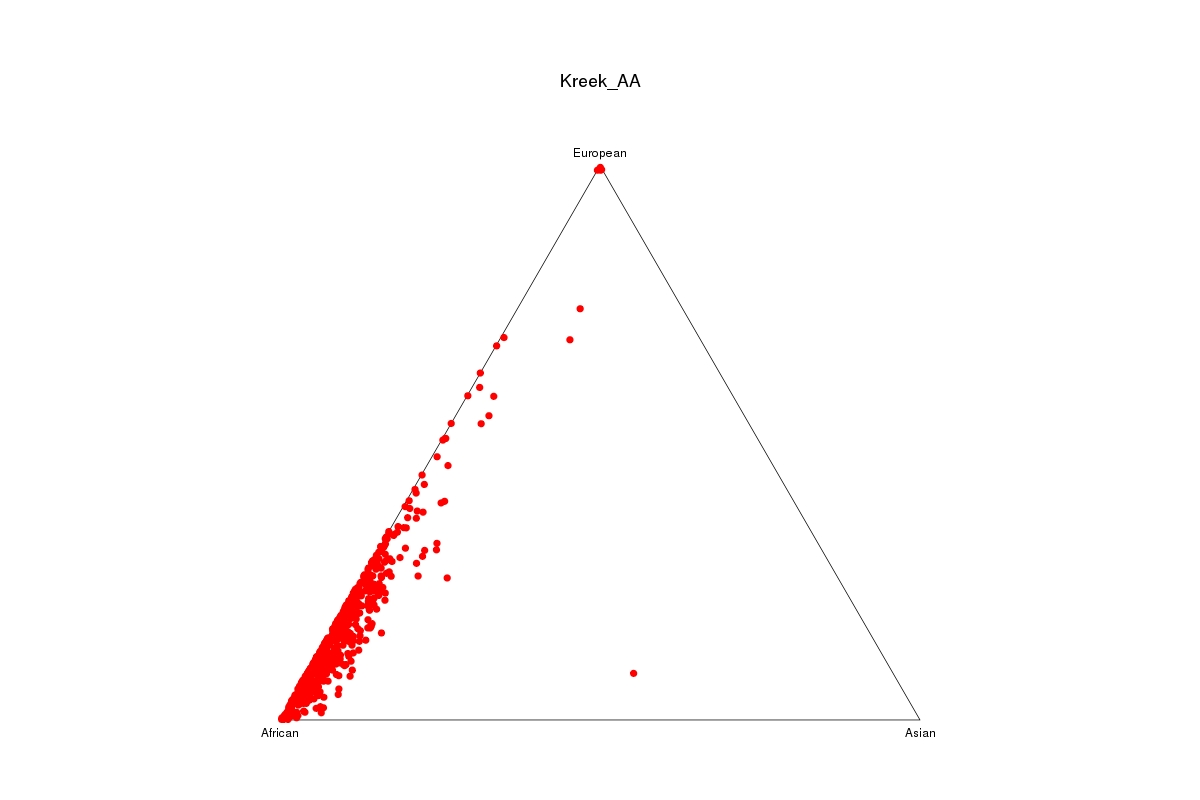

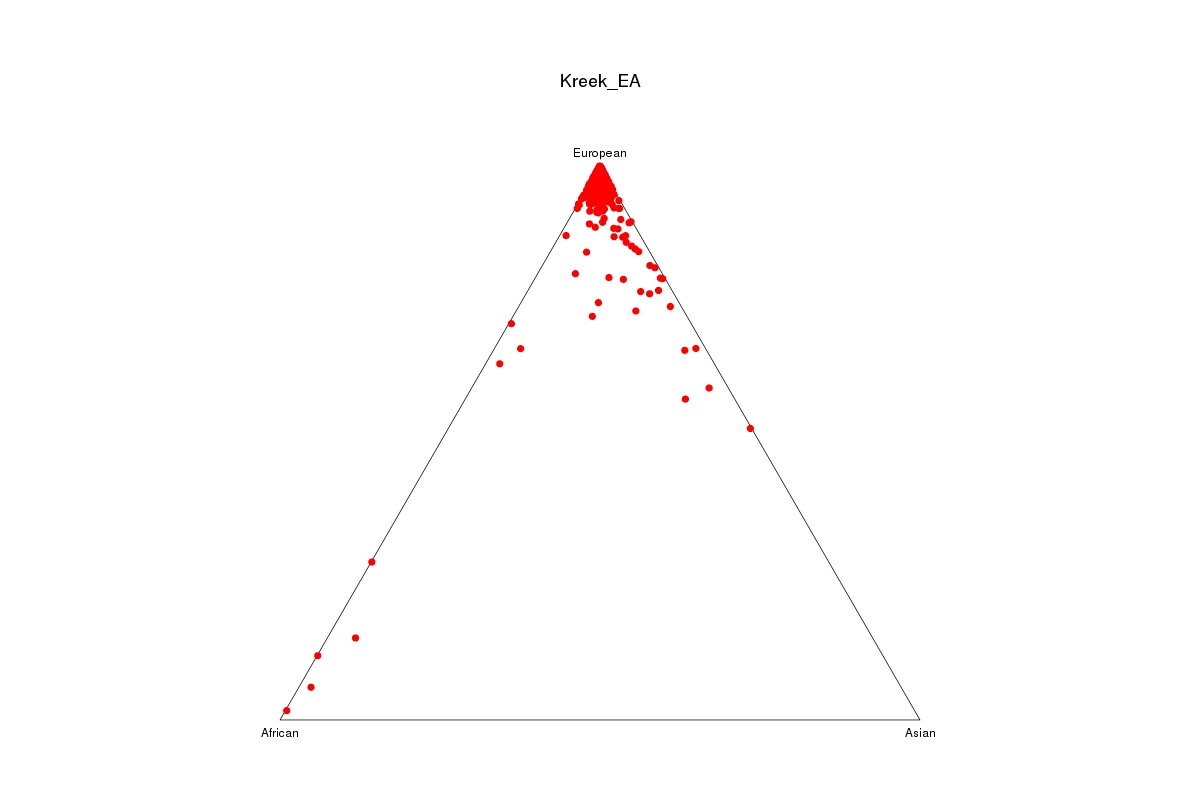

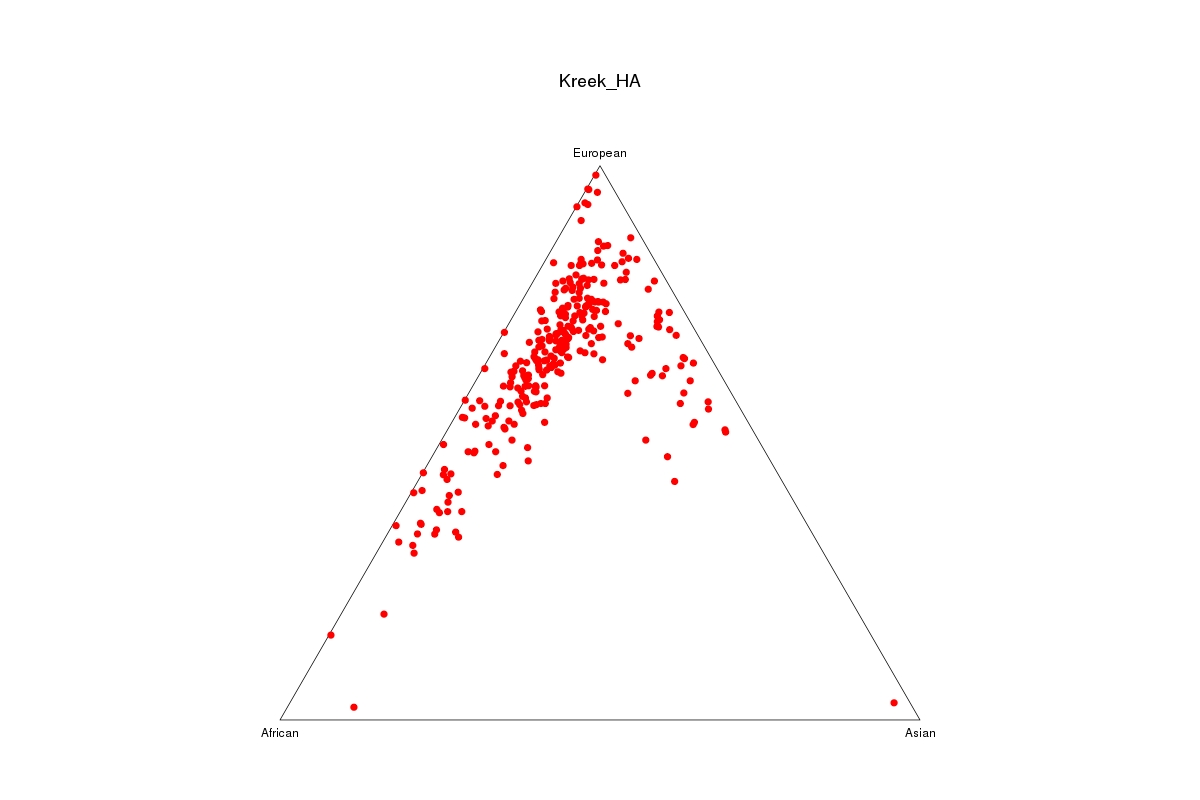

In [5]:
## R console ##
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/afr_eas_eur_Kreek_AA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/afr_eas_eur_Kreek_EA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/afr_eas_eur_Kreek_HA.jpg", width=800, height=800)

#### Reassigning and removing outliers
Based on the triangle plots and discussions with Bryan Quach,re how to handle ancestral outliers, the following retainment thresholds will be implemented:


| Action Description | Thresholding Criteria      |
|--------------------|----------------------------|
| For EA retainment | (AFR < 25%)$ \wedge $(EAS < 25%) |
| For AA retainment | (AFR > 25%)$ \wedge $(EAS < 25%) |
| For HA retainment | (AFR < 25%)$ \wedge $(EAS > 25%) |

* We might add the upperbound threshold to the HA subjects such that if EAS > 0.75 we filter that subject.

**Note:** For the Hispanics we are essentially keeping anyone that's not too similar to AFR or EUR ancestry.

In [ ]:
## EC2 command line ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Create triangle plot input with potential outliers filtered
head -1 structure/triangle_plots/afr_eas_eur.triangle_input >\
    structure/triangle_plots/afr_eas_eur_filtered_aa.triangle_input

# AA retained
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input | \
    perl -lane 'if ($F[2] eq "Kreek_AA" && ($F[3] > 0.25 && $F[4] < 0.25)) { print $_; }' \
    >> structure/triangle_plots/afr_eas_eur_filtered_aa.triangle_input

# Create triangle plot input with potential outliers filtered
head -1 structure/triangle_plots/afr_eas_eur.triangle_input >\
    structure/triangle_plots/afr_eas_eur_filtered_ea.triangle_input

# EA retained
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input |\
    perl -lane 'if ($F[2] eq "Kreek_EA" && ($F[5] > 0.75 && $F[4] < 0.25)) { print $_; }' \
    >> structure/triangle_plots/afr_eas_eur_filtered_ea.triangle_input


# Create triangle plot input with potential outliers filtered
head -1 structure/triangle_plots/afr_eas_eur.triangle_input >\
    structure/triangle_plots/afr_eas_eur_filtered_ha.triangle_input

# HA retained
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input \
    perl -lane 'if ($F[2] eq "Kreek_HA" && ($F[4] > 0.25 && $F[3] < 0.25)) { print $_; }' \
    >> structure/triangle_plots/afr_eas_eur_filtered_ha.triangle_input



# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data structure/triangle_plots/afr_eas_eur_filtered_aa.triangle_input \
    --prefix structure/triangle_plots/afr_eas_eur_filtered_aa \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European

Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data structure/triangle_plots/afr_eas_eur_filtered_ea.triangle_input \
    --prefix structure/triangle_plots/afr_eas_eur_filtered_ea \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European


Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data structure/triangle_plots/afr_eas_eur_filtered_ha.triangle_input \
    --prefix structure/triangle_plots/afr_eas_eur_filtered_ha \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European

In [22]:
library(tidyverse)
library(gridExtra)
library(grid)
library(png)
library(downloader)
library(grDevices)


ERROR: Error in library(tidyverse): there is no package called 'tidyverse'


In [16]:
getwd()

[1] "C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/develop"

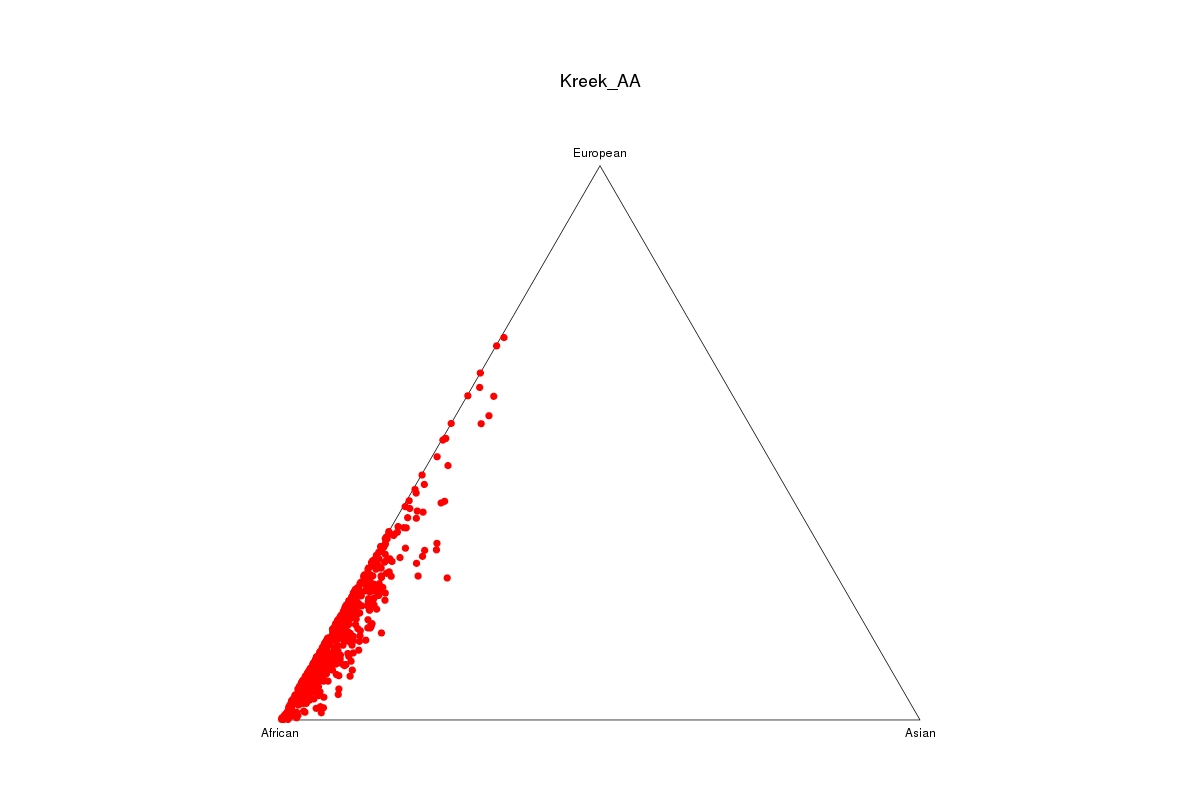

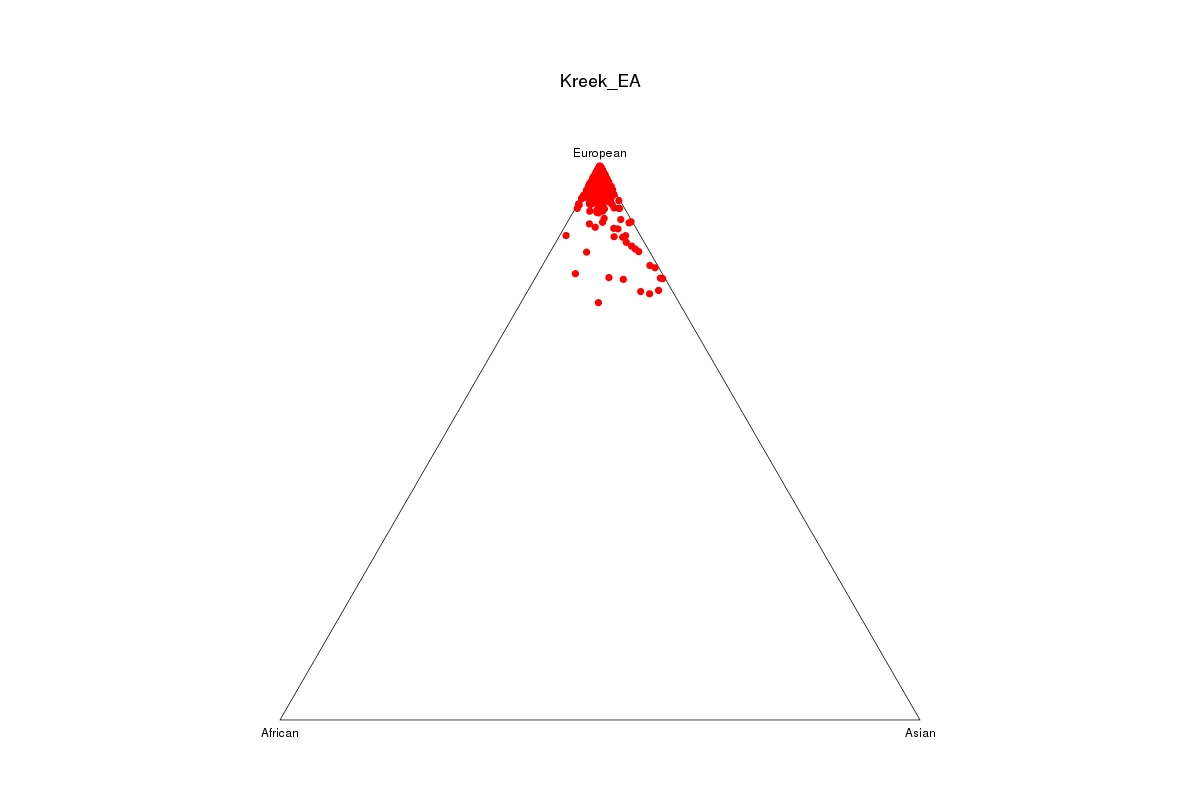

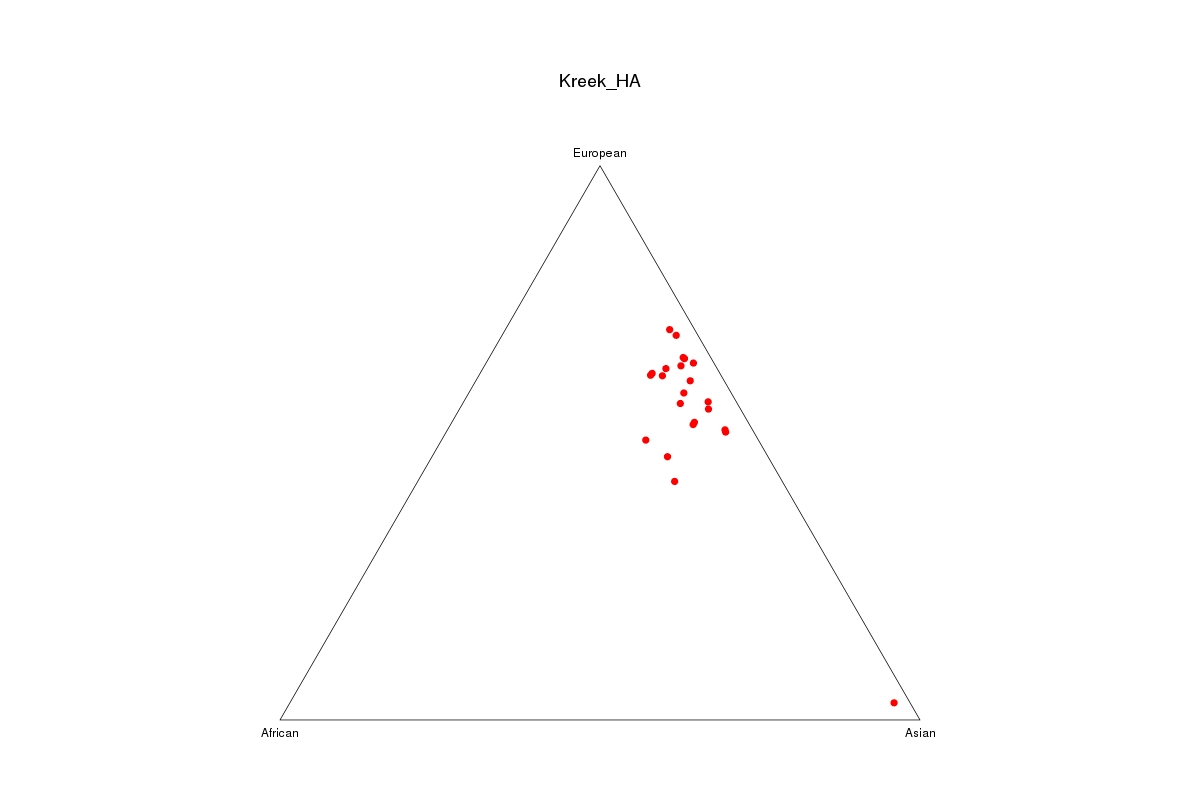

In [9]:
## R console ##
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/afr_eas_eur_filtered_aa_Kreek_AA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/afr_eas_eur_filtered_ea_Kreek_EA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/afr_eas_eur_filtered_ha_Kreek_HA.jpg", width=800, height=800)

#### Reassigning (Part 2)
Because so many Hispanic subjects were removed from the previous filtering scheme, we will try a different approach. We are going to keep the same filters as before, namely:

| Action Description | Thresholding Criteria     |
|--------------------|---------------------------|
| For HA retainment  | (AFR < 25%) ∧ (EAS > 25%) |
| For AA retainment  | (AFR > 25%) ∧ (EAS < 25%) |
| For EA retainment  | (AFR < 25%) ∧ (EAS < 25%) |


This time, we are going to ignore the self-reported data though. 

In [ ]:
## EC2 ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/structure/triangle_plots/
mkdir sandbox

cp afr_eas_eur.triangle_input sandbox
cd sandbox

# create three files based on the filtering criteria in the table above.

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
head -1 afr_eas_eur.triangle_input > afr_eas_eur_filtered_aa.triangle_input

tail -n +2 afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_; }' \
    >> afr_eas_eur_filtered_aa.triangle_input

# Number of AA without pre-filtered
awk ' $3=="Kreek_AA"' afr_eas_eur.triangle_input | wc -l 
"""598"""

# Number of AA remaining post-filtered
awk ' $3=="Kreek_AA"' afr_eas_eur_filtered_aa.triangle_input | wc -l 
"""591"""

# Number of non-AA subjects added
awk 'NR>=2{ if($3!="Kreek_AA") {print $0}}' afr_eas_eur_filtered_aa.triangle_input | wc -l 
"""128"""

# Total number of subjects clasified as AA (don't forget to account for the header)
wc -l afr_eas_eur_filtered_aa.triangle_input
"""720""" # so actually 719


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
head -1 afr_eas_eur.triangle_input > afr_eas_eur_filtered_ea.triangle_input

tail -n +2 afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    >> afr_eas_eur_filtered_ea.triangle_input

# Number of EA without pre-filtered
awk ' $3=="Kreek_EA"' afr_eas_eur.triangle_input | wc -l 
"""651"""

# Number of EA remaining post-filtered
awk ' $3=="Kreek_EA"' afr_eas_eur_filtered_ea.triangle_input | wc -l 
"""638"""

# Number of non-EA subjects added
awk 'NR>=2{ if($3!="Kreek_EA") {print $0}}' afr_eas_eur_filtered_ea.triangle_input | wc -l 
"""164"""

# Total number of subjects clasified as EA (don't forget to account for the header)
wc -l afr_eas_eur_filtered_ea.triangle_input
"""803""" # so actually 802 


# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
head -1 afr_eas_eur.triangle_input > afr_eas_eur_filtered_ha.triangle_input

tail -n +2 afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] > 0.25)) { print $_; }' \
    >> afr_eas_eur_filtered_ha.triangle_input

# Number of HA without pre-filtered
awk ' $3=="Kreek_HA"' afr_eas_eur.triangle_input | wc -l 
"""302"""

# Number of HA remaining post-filtered
awk ' $3=="Kreek_HA"' afr_eas_eur_filtered_ha.triangle_input | wc -l 
"""23"""

# Number of non-HA subjects added
awk 'NR>=2{ if($3!="Kreek_HA") {print $0}}' afr_eas_eur_filtered_ha.triangle_input | wc -l 
"""5"""

# Total number of subjects clasified as HA (don't forget to account for the header)
wc -l afr_eas_eur_filtered_ha.triangle_input
"""29""" # so actually 28 

#--------------------------------------------------------------------------------

# find out which subjects were not included in any of the groups post-filter

# subject was not included in any 
#awk ' $3=="0.250" || $4=="0.250" || $5=="0.250"' afr_eas_eur.triangle_input
#"""3158    0_106395        Kreek_HA        0.250   0.109   0.641"""

awk ' NR>=2 {print $2} ' afr_eas_eur.triangle_input > id1
awk ' NR>=2 {print $2} ' afr_eas_eur_filtered_aa.triangle_input > id2
awk ' NR>=2 {print $2} ' afr_eas_eur_filtered_ea.triangle_input >> id2
awk ' NR>=2 {print $2} ' afr_eas_eur_filtered_ha.triangle_input >> id2

sort id1 > id1.sorted
sort id2 > id2.sorted
comm -23 id1.sorted id2.sorted
"""0_102854
0_106395"""
grep 0_102854 afr_eas_eur.triangle_input
"""2065    0_102854        Kreek_AA        0.405   0.510   0.084"""
grep 0_106395 afr_eas_eur.triangle_input
"""3158    0_106395        Kreek_HA        0.250   0.109   0.641"""
# EXCLUDE both


#--------------------------------------------------------------------------------
# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data afr_eas_eur_filtered_aa.triangle_input \
    --prefix afr_eas_eur_filtered_aa \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European

Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data afr_eas_eur_filtered_ea.triangle_input \
    --prefix afr_eas_eur_filtered_ea \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European


Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data afr_eas_eur_filtered_ha.triangle_input \
    --prefix afr_eas_eur_filtered_ha \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European


| Ancestry | Subjects Pre-Filtering | Subjects Removed | Subjects Added | Subjects Post-Filtering |
|----------|------------------------|------------------|----------------|-------------------------|
| EA       | 651                    | 13               | 164            | 802                     |
| AA       | 598                    | 7                | 128            | 719                     |
| HA       | 302                    | 279              | 5              | 28                      |

In [ ]:
## EC2 ##
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/structure/triangle_plots/
mkdir sandbox

cp afr_eas_eur.triangle_input sandbox
cd sandbox

# create three files based on the filtering criteria in the table above.

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
head -1 afr_eas_eur.triangle_input > afr_eas_eur_filtered.triangle_input

tail -n +2 afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    >> aa_filtered
awk '{$3="Kreek_AA";print $0}' aa_filtered >> afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered

tail -n +2 afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    >> ea_filtered
awk '{$3="Kreek_EA";print $0}' ea_filtered >> afr_eas_eur_filtered.triangle_input


# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered

tail -n +2 afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] > 0.25)) { print $_; }' \
    >> ha_filtered
awk '{$3="Kreek_HA";print $0}' ha_filtered >> afr_eas_eur_filtered.triangle_input

#--------------------------------------------------------------------------------

# find out which subjects were not included in any of the groups post-filter

# subject was not included in any 
#awk ' $3=="0.250" || $4=="0.250" || $5=="0.250"' afr_eas_eur.triangle_input
#"""3158    0_106395        Kreek_HA        0.250   0.109   0.641"""

awk ' NR>=2 {print $2} ' afr_eas_eur.triangle_input > id1
awk ' NR>=2 {print $2} ' afr_eas_eur_filtered_aa.triangle_input > id2
awk ' NR>=2 {print $2} ' afr_eas_eur_filtered_ea.triangle_input >> id2
awk ' NR>=2 {print $2} ' afr_eas_eur_filtered_ha.triangle_input >> id2

sort id1 > id1.sorted
sort id2 > id2.sorted
comm -23 id1.sorted id2.sorted
"""0_102854
0_106395"""
grep 0_102854 afr_eas_eur.triangle_input
"""2065    0_102854        Kreek_AA        0.405   0.510   0.084"""
grep 0_106395 afr_eas_eur.triangle_input
"""3158    0_106395        Kreek_HA        0.250   0.109   0.641"""


#--------------------------------------------------------------------------------
# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data afr_eas_eur_filtered.triangle_input \
    --prefix afr_eas_eur_filtered \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European


In [ ]:
# local #
cd ~/Desktop
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/data/studies/phs001109_kreek/genotype/original/processing/structure/triangle_plots/sandbox/*.jpg .

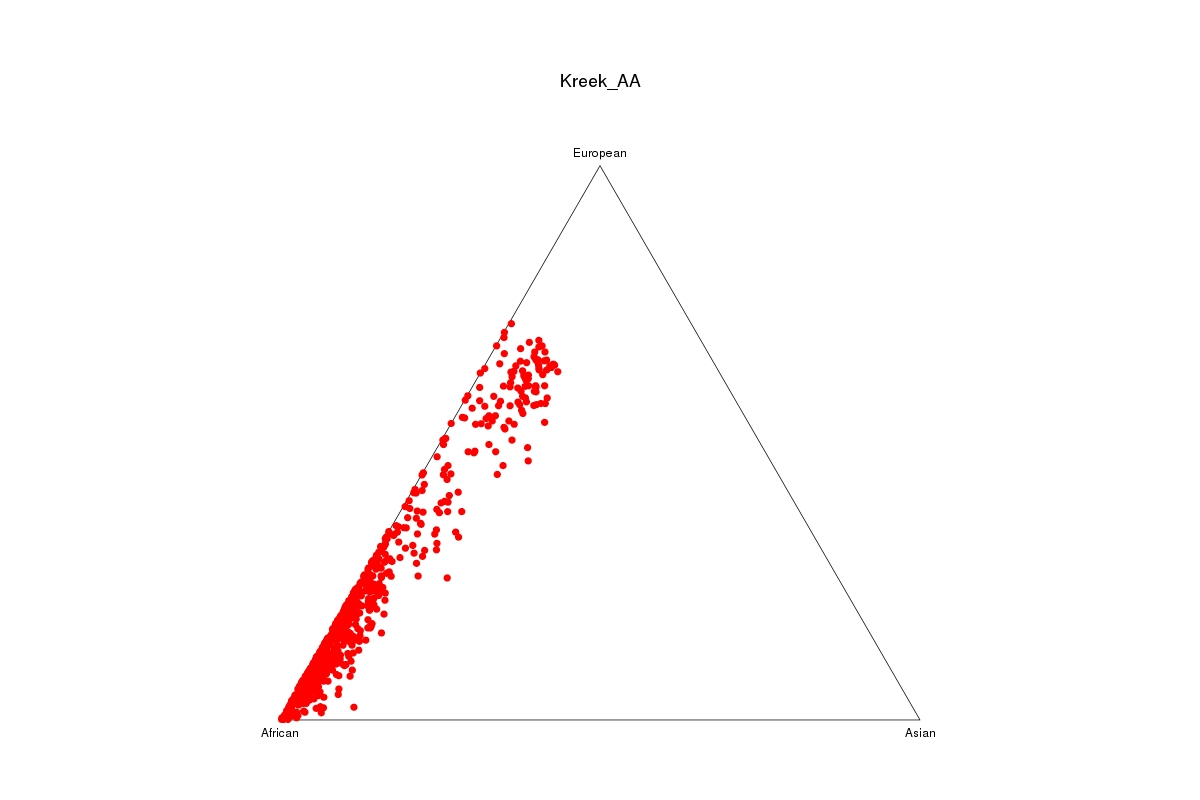

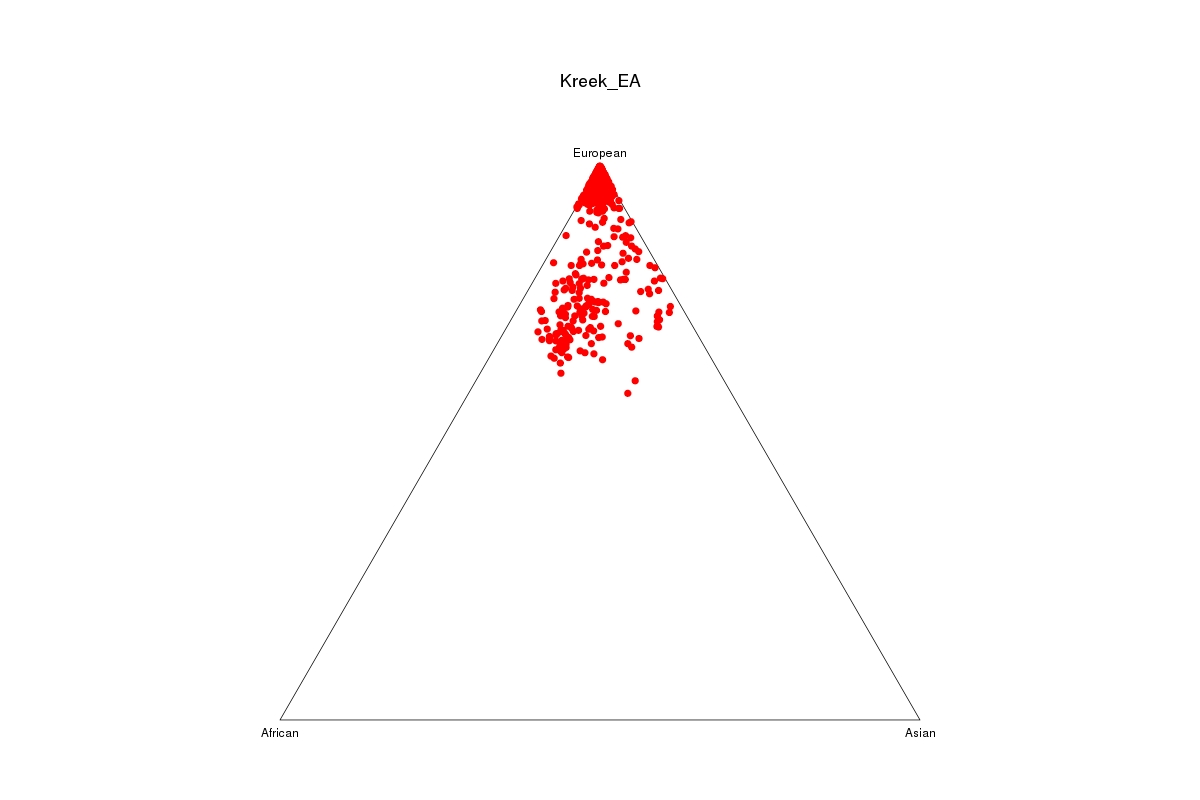

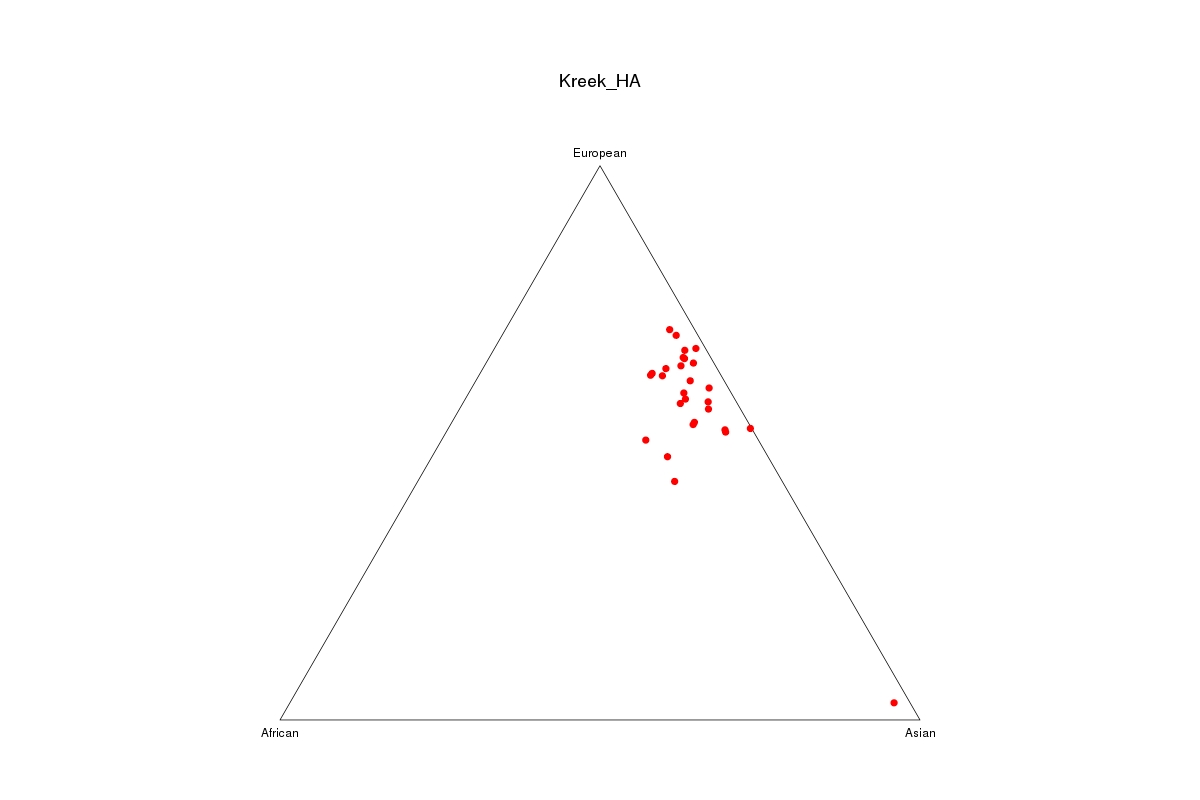

In [1]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/filtered_disregard_self_report/afr_eas_eur_filtered_Kreek_AA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/filtered_disregard_self_report/afr_eas_eur_filtered_Kreek_EA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/Desktop/GitHub/jaamarks_notebooks/Heroin_Project/figures/1109_kreek/filtered_disregard_self_report/afr_eas_eur_filtered_Kreek_HA.jpg", width=800, height=800)

Here is a breakdown of the filtering results. These results are based on filtering exclusively by the ancestral thresholds - disregarding self-report information.  

| Ancestry | Subjects Pre-Filtering | Subjects Removed | Subjects Added | Subjects Post-Filtering |
|----------|------------------------|------------------|----------------|-------------------------|
| EA       | 651                    | 13               | 164            | 802                     |
| AA       | 598                    | 7                | 128            | 719                     |
| HA       | 302                    | 279              | 5              | 28                      |

**Note**: as I discussed with @danahancock today, two subjects were completely excluded as a result of the filters applied. 

| Self-reported | AFR   | EAS   | EUR   |
|---------------|-------|-------|-------|
| AA            | 0.405 | 0.510 | 0.084 |
| HA            | 0.250 | 0.109 | 0.641 |

* It was decided to not proceed with the Hispanics because after filtering there are not enough subjects left
* I will proceed with the the retainment and reassignment of the EAs and AAs

#### Create reassignment and remove lists 


| Ancestry | Subjects Pre-Filtering | Subjects Retained | Subjects Absorbed | Subjects Post-Filtering |
|----------|------------------------|------------------|---------------------------------------|-------------------------|
| EA       | 651                    |   638            | 6                                     |644                      |
| AA       | 598                    |   591            | 8                                     |599                      |


In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# AA to keep
## AFR > 25% and EAS < 25% ##
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input | \
    perl -lane 'if ($F[2] eq "Kreek_AA" && ($F[3] > 0.25 && $F[4] < 0.25)) { $F[1] =~ /(\S+)_(\S+)/; print $1." ".$2; }' \
    > aa/autosomes/structure.keep
wc -l aa/autosomes/structure.keep
"""591"""

# Self reported AA that are reassigned to EA
## AFR<25% and EAS<25% ##
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input | \
    perl -lane 'if ($F[2] eq "Kreek_AA" && ($F[3] < 0.25 && $F[4] < 0.25)) { $F[1] =~ /(\S+)_(\S+)/; print $1." ".$2; }' \
    > ea/autosomes/structure.keep
wc -l ea/autosomes/structure.keep
"""6"""

# EA to keep
## AFR<25% and EAS<25% ##
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input | \
    perl -lane 'if ($F[2] eq "Kreek_EA" && ($F[3] < 0.25 && $F[4] < 0.25)) { $F[1] =~ /(\S+)_(\S+)/; print $1." ".$2; }' \
    >> ea/autosomes/structure.keep
wc -l ea/autosomes/structure.keep
"""644"""

# Self reported EA that are reassigned to AA
tail -n +2 structure/triangle_plots/afr_eas_eur.triangle_input | \
    perl -lane 'if ($F[2] eq "Kreek_EA" && ($F[3] > 0.25 && $F[4] < 0.25)) { $F[1] =~ /(\S+)_(\S+)/; print $1." ".$2; }' \
    >> aa/autosomes/structure.keep
wc -l aa/autosomes/structure.keep
"""599"""


# Create master subject lists
cat aa/autosomes/structure.keep | sort > aa/updated_subject_ids.keep
cat ea/autosomes/structure.keep | sort > ea/updated_subject_ids.keep

## Create updataed PLINK filesets

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# clean up previous processing 
rm -rf {aa,ea}/{autosomes,chrX}
rm {aa,ea}/chr*flipped*

for ancestry in {aa,ea}; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile genotypes_b37_dbsnp138 \
        --keep ${ancestry}/updated_subject_ids.keep \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138
done

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Create autosome and chrX file sets
for ancestry in {aa,ea}; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    mkdir ${ancestry}/{chrX,autosomes}

    # Autosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile ${ancestry}/genotypes_b37_dbsnp138 \
        --autosome \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138

    # ChrX (include split PARs)
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile ${ancestry}/genotypes_b37_dbsnp138 \
        --chr 23,25 \
        --make-bed \
        --out ${ancestry}/chrX/genotypes_b37_dbsnp138_unmerged

    # Combine split chrX and PARs
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile ${ancestry}/chrX/genotypes_b37_dbsnp138_unmerged \
        --merge-x \
        --make-bed \
        --out ${ancestry}/chrX/genotypes_b37_dbsnp138
done

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get flip lists

# Extract unflipped variants
for ancestry in {aa,ea}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --make-bed \
                --out ${ancestry}/chr${chr}_unflipped
    done
done


# Attempt merge with 1000G data
for ancestry in {aa,ea}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/chr${chr}_unflipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --merge-mode 7 \
                --out ${ancestry}/chr${chr}_unflipped_test
    done
done

# Flip problematic variants
for ancestry in {aa,ea}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --flip ${ancestry}/chr${chr}_unflipped_test.missnp \
                --make-bed \
                --out ${ancestry}/chr${chr}_flipped
    done
done

# Attempt merge with 1000G data
for ancestry in {aa,ea}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix ${ancestry}/autosomes/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile ${ancestry}/chr${chr}_flipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --merge-mode 7 \
                --out ${ancestry}/chr${chr}_flipped_test
    done
done

# Combine flip lists
for ancestry in {aa,ea}; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    cat ${ancestry}/chr*_unflipped_test.missnp | sort -u > ${ancestry}/chr_all_unflipped_test.missnp
    cat ${ancestry}/chr*_flipped_test.missnp | sort -u > ${ancestry}/chr_all_flipped_test.missnp
    comm -23 ${ancestry}/chr_all_unflipped_test.missnp ${ancestry}/chr_all_flipped_test.missnp \
        > ${ancestry}/autosomes/chr_all.flip
    
    # Perform final flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138 \
        --flip ${ancestry}/autosomes/chr_all.flip \
        --exclude ${ancestry}/chr_all_flipped_test.missnp \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped
done

# Clean up
rm {aa,ea}/chr*flipped*
rm {aa,ea}/autosomes/chr*flip*

## Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate >3%.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get missing call rate
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped \
        --geno 0.03 \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_filter
done

## Hardy-Weinberg equilibrium filtering
Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK --hardy, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Calculate HW p-values for each ancestry group
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_filter \
        --hwe 0.0001 \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_filter
done

## Genotype call rate subject filter
**Note**: The genotype call rate subject filtereing and the subsequent LD pruning are specifically for relatedness filtering calculations. Autosomes and chrX merging will be done using the PLINK file sets generated in the preceding step (HWE filtering).

I calculate the genotype missing call rate and remove any subjects with a rate > $3\%$.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Remove variants
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_filter \
        --mind 0.03 \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_lte_0.03_filter
done

## Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of identity-by-state (IBS) and identity-by-descent (IBD) calculations. Consequently, the LD pruned data will be used as input into IBS and IBD calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Run per chromosome LD pruning 
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix ${ancestry}/autosomes/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --priority 0 \
            --nslots 1 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_lte_0.03_filter \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out ${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_chr${chr}
    done
done


for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    # Merge *prune.in files
    cat ${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_chr*.prune.in \
        > ${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_lte_0.03_filter \
        --extract ${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter
done

## Identical-by-state and identical-by-descent filtering
Identical-by-state or identity-by-state (IBS) filtering provides a means to identify duplicate subjects or monozygotic twins. Identical-by-descent or identity-by-descent allows for detection of high relatedness. For computational efficiency and memory usage limitations, ibd_pipeline.v4.sh is used to perform IBS/IBD calculations on data chunks that are used as input for IBS and IBD filtering. If the study contains AA subjects, then for AA subjects only, [KING](http://people.virginia.edu/~wc9c/KING/manual.html) is used as an additional relationship inference tool for filtering.

For these filtering steps, a list of individuals is identified separately for each filtering type then combined into a final list for exclusion. Following IBS filtering, if any individuals are identified for removal, a graph analysis needs to be done to account for an individual being related/identical to multiple individuals. Removal criteria is based on genotype calling rate. These individuals would need to be removed before running IBD filtering and KING. Graph analysis would need to be run after IBD calculations/KING if individuals were selected for removal.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

 Calculate allele frequencies in data chunks
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter \
        --out_dir ${ancestry}/autosomes/
    sleep 5s
done


# Aggregate data
for ancestry in {ea,aa}; do
    outfile=${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter.genome
    head -1 `ls ${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat ${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm ${ancestry}/autosomes/data.sub.*
    rm ${ancestry}/autosomes/tmp_sh*.sh
done

### IBS filtering
For individual pairs with greater than 0.9 IBS score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBD list for final filtering but removed from the LD pruned data before running IBD filtering.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Calculate missingness
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_filter \
        --missing \
        --out ${ancestry}/autosomes/autosome_missing_call_rate
done

# Get list of individuals with IBS > 0.9
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter.genome \
        --imiss ${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBS \
        --out ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done

There are X individuals that are problematic for the EAs and X for the AA subjects.

### Graph Analysis for IBS
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
library(igraph)
setwd("/shared/data/studies/phs001109_kreek/genotype/original/processing")
for(ancestry in c("ea","aa")){
    stats = read.table(paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

### Remove IBS problematic subjects
Before proceeding with IBD filtering, the problematic subjects need to be removed.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing


# Make new PLINK file set
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter \
        --remove ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove \
        --make-bed \
        --out ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done

# Calculate allele frequencies in data chunks
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter \
        --out_dir ${ancestry}/autosomes/
    sleep 5s
done

# Aggregate data
for ancestry in {ea,aa}; do
    outfile=${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome
    head -1 `ls ${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat ${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm ${ancestry}/autosomes/data.sub.*
    rm ${ancestry}/autosomes/tmp_sh*.sh
done

### IBD filtering
For individual pairs with greateer than 0.4 IBD score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBS list.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get list of individuals with IBD > 0.4
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome \
        --imiss ${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBD \
        --pi_hat_threshold 0.4 \
        --out ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter
done

 wc -l ea/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter
 wc -l aa/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter

### Relationship inference using KING
For subjects with AFrican ancestry, KING provides a better estimation of relatedness. I use this software to further identify subjects for removal.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Run KING
/shared/bioinformatics/software/third_party/king_v2.1.2/king \
    -b aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.bed \
    --kinship \
    --cpus 1 \
    --prefix aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king

# Extract PLINK IBD calculations for subject pairs
outFile=aa/autosomes/genotypes_for_relatedness.genome_lite
echo -e "PAIR_ID\tPI_HAT" > $outFile
tail -n +2 aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome | \
    perl -lane '$pairId = "";
        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
        } else {
            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
        }
        print $pairId."\t".$F[9];' >> $outFile

# Extract KING kinship calculations for subject pairs
outFile=aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite
echo -e "PAIR_ID\tKINSHIP" > $outFile
tail -n +2 aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin0 | \
    perl -lane '$pairId = "";
        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
        } else {
            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
        }
        print $pairId."\t".$F[7];' >> $outFile

tail -n +2 aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin | \
    perl -lane '$pairId = "";
        if ($F[1] < $F[2]) {
            $pairId = join("_",$F[0],$F[1],$F[0],$F[2]);
        } else {
            $pairId = join("_",$F[0],$F[2],$F[0],$F[1]);
        }
        print $pairId."\t".$F[8];' >> $outFile

# Combine IBD and kinship results
Rscript /shared/bioinformatics/software/R/merge_datasets.R \
    --in_1 aa/autosomes/genotypes_for_relatedness.genome_lite \
    --in_1_column PAIR_ID \
    --in_1_header \
    --in_2 aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite \
    --in_2_column PAIR_ID \
    --in_2_header \
    --out aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king \
    --out_header

# Identify discrepancies between PLINK IBD and KING kinship values
perl -lane 'if ($F[2] > 0.177 && $F[1] > 0.4) { print "AGREE\t".$_; } elsif ($F[2] > 0.177 || $F[1] > 0.4) { print "DISAGREE\t".$_; }' aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king \
    > aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king.ibd_comparison

### Graph Analysis for IBD
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get genotype missing call rate for graph analysis
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_lte_0.03_filter \
        --missing \
        --out ${ancestry}/autosomes/genotypes_for_relatedness
done

** Note**, 

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
library(igraph)
setwd("/shared/data/studies/phs001109_kreek/genotype/original/processing")
for(ancestry in c("aa")){
    stats = read.table(paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

### Constructing relatedness filtering lists
The output of the IBS filtering and the IBD filtering are combined into a single remove list.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get list of individuals from IBD and IBS filter lists
ancestry=aa
cat ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove \
    ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove | \
    sort -u > ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove

ancestry=ea
cat ${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove | \
    sort -u > ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove

The list of subjecs marked for will be retained as a filtering list for the merged autosome and chrX PLINK file sets.

## ChrX Processing 
### Missing data subject filtering
We calculate the proportion of missing genotype calls on chrX using PLINK to assess whether any subjects have data missing for the whole chromosome.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get missing call rate for chrX
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile ${ancestry}/chrX/genotypes_b37_dbsnp138 \
            --missing \
            --chr 23 \
            --out ${ancestry}/chrX/chrX_missing_call_rate

    # Find subjects that have data missing for whole chrX
    tail -n +2 ${ancestry}/chrX/chrX_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> ${ancestry}/chrX/missing_whole_chrX.remove
    echo -e "\n\nNumber of ${ancestry} subjects with missing whole chromosome: $(wc -l ${ancestry}/chrX/missing_whole_chrX.remove)\n\n"
done

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Remove identified subjects from all autosomes
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} autosomes ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_filter \
            --remove ${ancestry}/chrX/missing_whole_chrX.remove \
            --make-bed \
            --out ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_filter   
done

# Remove identified subjects from chrX
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} chrX ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/chrX/genotypes_b37_dbsnp138 \
        --remove ${ancestry}/chrX/missing_whole_chrX.remove\
        --make-bed \
        --out ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_subject_missing_chrx
done

##EC2 command line 
rm {ea,aa}/chrX/chr*missing_call_rate*

### Remove duplicate SNPs

If multiple rsIDs are present then the one with the better genotype call rate across subjects should be retained. Obtaining the genotype call rates across subjects would need to be calculated using PLINK --missing.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Find duplicate rsIDs
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    cut -f2,2 ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_subject_missing_chrx.bim | \
    sort | \
    uniq -D \
    > ${ancestry}/chrX/snp_duplicates.txt
    echo -e "\n\nNumber of ${ancestry} variant duplicates: $(wc -l ${ancestry}/chrX/snp_duplicates.txt)\n\n"
done

For this case, there are no duplicated rsIDs.

### Strand flipping
If strand flipping was an issue for the autosomes, it would also be an issue for chrX. Unfortunateley the May 2013 release for the 1000 Genomes Phase 3 data lacks IDs for chrX, so strand flipping for chrX will need to be done after converting IDs to 1000 Genomes Phase 3 IMPUTE2 format in a subsequent step. If complete data were available, strand flipping would be executed at this point.

### Genotype call rate variant filter

I calculate the genotype missing call rate and remove any variants with a rate $> 3\%$.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get missing call rate
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_subject_missing_chrx \
        --geno 0.03 \
        --make-bed \
        --out ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_filter_subject_missing_chrx
done

### Hardy-Weinberg equilibrium filtering

Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK `--hardy`, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Calculate HW p-values for each ancestry group
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --memory 3800 \
        --noweb \
        --bfile ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_filter_subject_missing_chrx \
        --hwe 0.0001 \
        --make-bed \
        --out ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_filter_subject_missing_chrx
done

## Merge autosomes and chrX
The data processed through to HWE filtering for both the autosomes and chrX are merged before applying the final subject filtering steps.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_filter \
        --bmerge ${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_filter_subject_missing_chrx \
        --make-bed \
    --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr
done

## Relatedness filter
From relatedness calculations on the autosomal data, I remove subjects that are closely related or seemingly identical.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Remove variants
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr \
        --remove ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_filter.all_chr
    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove)\n\n"
done

## Genotype call rate subject filter

I calculate the genotype missing call rate and remove any subjects with a rate $> 3\%$.



In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Remove variants
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_filter.all_chr \
        --mind 0.03 \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_filter.all_chr
done

## Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of sex check and excessive homozygosity calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Run per chromosome LD pruning for each chr
for ancestry in {ea,aa}; do
    for chr in {1..23}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix ${ancestry}/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --nslots 1 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_filter.all_chr \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr${chr}_filter
    done
done

# Merge *prune.in files
for ancestry in {ea,aa}; do
    cat ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr*_filter.prune.in \
        > ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_filter.all_chr \
        --extract ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter.prune.in \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter
done

## Sex Check
To verify that self-reported gender status matches with the genetic information, I use PLINK `--split-x` followed by `--check-sex` to confirm the data agree. Our discrepancy criteria are

* Reported as male (coded as 1) but F < 0.2
* Reported as female (coded as 2) but F > 0.8

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Break out the pseudo-autosomal region on chrX (will be stored as chr 25)
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter \
        --split-x b37 \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr

    # Run sex check
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr \
        --check-sex \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr

    # Get subjects that do not meet inbreeding coefficient thresholds
    perl -lane 'if ($F[2]==1 && $F[5]<0.2) { print $_; } elsif ($F[2]==2 && $F[5]>0.8) { print $F[0]."\t".$F[1]; }' ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck \
        > ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck.threshold_fail

    # Get subjects that are problematic due to no inbreeding coefficient value
    perl -lane 'if ($F[4] eq "PROBLEM" && $F[5] eq "nan") { print $F[0]."\t".$F[1]; }' ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck \
        > ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck.nan_fail

    # Combine discordant subjects into one remove list
    cat ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck.*_fail | \
        sort -u \
        > ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck.remove
done

# Print number of discrepancies
wc -l {ea,aa}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck.remove
For these data the sex check yielded 3 discrepancies for the EA subjects and 0 discrepancies for the AA subjects under our criteria. If any individuals failed the check then they would be removed before subsequent steps using the file set generated after gentoype call rate subject filtering (before removing the pseudo-autosomal chrX region).

### Remove subjects that failed the sex check

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# remove the individuals who failed sex check (note only EA subjecs failed but we will
# process the AA subjects as if there were AA subjects who failed too. 
# this keeps the naming convention easier.)

for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_filter.all_chr \
        --remove ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_split_chrX_filter.all_chr.sexcheck.remove \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_filter.all_chr
done

## Excessive homozygosity filter
Excessive homozygosity checks for inbreeding and population substructure. This check is implemented using PLINK. According to their documentation, the statistics used for this filtering are not LD-sensitive, i.e., an LD pruned dataset is recommended as input. Additionally, the documentation states that only autosomal data are used, so concerns of chrX biasing results are irrelevant.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Get homozygosity stats
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter \
        --het \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter

   # Identify problematic subjects
    perl -lane 'if ($F[5] < -0.2 || $F[5] > 0.5) { print $F[0]." ".$F[1]; }' ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_chr_all_filter.het \
    > ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_homozygosity_check_chr_all_filter.remove

    # Remove problematic subjects
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_filter.all_chr \
        --remove ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_homozygosity_check_chr_all_filter.remove \
        --make-bed \
        --out ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_homozygosity_check_filter.all_chr

    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_homozygosity_check_chr_all_filter.remove)\n\n"
done

## Recoding variants for 1000G phase 3
RefSeq IDs (rsIDs) for variants can vary depending on the dbSNP build used and variant IDs do not all use RefSeq nomenclature. To provide a common nomenclature that will make comparisons across data sets feasible, I use a script that recodes all variant names to match 1000G phase 3 variants by position and alleles. The 1000G Phase 3 data I used for STRUCTURE are from /share/nas03/bioinformatics_group/data/ref_panels/1000G/2013.05/plink on MIDAS, but from correspondence with Nathan Gaddis I learned that /share/nas03/bioinformatics_group/data/ref_panels/1000G/2014.10/ also contains 1000G Phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the IMPUTE2 website and reformatted to be directly compatible with IMPUTE2.

The data in /share/nas03/bioinformatics_group/data/ref_panels/1000G/2014.10/ is used for variant name recoding, but the 1000G genotype information is acquired from /share/nas03/bioinformatics_group/data/ref_panels/1000G/2013.05/plink

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

mkdir 1000g_name_recoding

for ancestry in {ea,aa}; do
    for ext in {bed,bim,fam}; do
        cp  ${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_homozygosity_check_filter.all_chr.${ext} 1000g_name_recoding/${ancestry}_chr_all.${ext}
    done
done

### Variant ID updating
Because the 1000G data and the study data have RefSeq IDs (rsIDs) from different dbSNP builds, I standardize them using convert_to_1000g_ids.pl. In the study data set, certain indels may be represented as two variants, a monomorphic variant and an indel with the - symbol for one of the alleles. For example:

1   rs201826967  0.809   57873968   0   G
1   rs11284630   0.809   57873969   -   A

These two variants represent a G:GA indel and is coded as such in the 1000 Genomes data. The script to update the names to 1000 Genomes IMPUTE2 format will assign the same ID to these two variants. The duplicated IDs will cause problems for PLINK filtering, so I will remove the variant from a set of duplicate IDs that has the lower genotype call rate. Duplicates may arise for other reasons, and they will be filtered based on the same criterion.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

mkdir 1000g_data

# Break out data by chr
for ancestry in {ea,aa}; do
    for chr in {1..23}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bfile ${ancestry}_chr_all \
            --chr ${chr} \
            --make-bed \
            --out ${ancestry}_chr${chr}
    done
done


# Rename study autosome variant IDs
for ancestry in {ea,aa}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name recode_to_1000g_${chr} \
            --script_prefix ${ancestry}_chr${chr}_id_rename \
            --mem 6 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in ${ancestry}_chr${chr}.bim \
                --file_out ${ancestry}_chr${chr}_renamed.bim \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 0 \
                --file_in_id_col 1 \
                --file_in_chr_col 0 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr ${chr}
    done
done


# Rename study chrX variant IDs
chr=23
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix ${ancestry}_chr${chr}_id_rename \
        --mem 6 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in ${ancestry}_chr${chr}.bim \
            --file_out ${ancestry}_chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G autosome variant IDs
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix ${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
            --file_out 1000g_data/chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G chrX variant IDs
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name recode_to_1000g_${chr} \
    --script_prefix ${ancestry}_chr${chr}_id_rename \
    --mem 8 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bim \
        --file_out 1000g_data/chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
        --chr ${chr}

### Remove duplicate variant ID
Many of the functions in PLINK will throw errors when duplicate variant IDs are found.To resolve this, duplicate variant IDs are identified, and only the duplicate variant with the best genotype call rate is retained.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

for ancestry in {ea,aa}; do
    for chr in {1..23}; do
        echo -e "\n ==== ${ancestry} - chr${chr} ==== \n"
        # Append _X (where X is a number) to the end of the variant IDs for all but 1st occurrence of duplicates
        perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    }' ${ancestry}_chr${chr}_renamed.bim > \
            ${ancestry}_chr${chr}_renamed_dups.bim

        # Generate list of duplicate SNPs
        grep -P "_[1-9]" ${ancestry}_chr${chr}_renamed_dups.bim |
            perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' > \
            ${ancestry}_chr${chr}_renamed_dups.dupvar_list
    done
done

# Check if any duplicates were found
wc -l *.dupvar_list

for ancestry in {ea,aa}; do
    for chr in $(wc -l *.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
# Get call rates for duplicate SNPs
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed ${ancestry}_chr${chr}.bed \
            --bim ${ancestry}_chr${chr}_renamed_dups.bim \
            --fam ${ancestry}_chr${chr}.fam \
            --extract ${ancestry}_chr${chr}_renamed_dups.dupvar_list \
            --missing \
            --out ${ancestry}_chr${chr}_renamed_dups

        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed ${ancestry}_chr${chr}.bed \
            --bim ${ancestry}_chr${chr}_renamed_dups.bim \
            --fam ${ancestry}_chr${chr}.fam \
            --extract ${ancestry}_chr${chr}_renamed_dups.dupvar_list \
            --missing \
            --out ${ancestry}_chr${chr}_renamed_dups

        # Create remove list that contains the duplicate with the higher missing rate
        tail -n +2 ${ancestry}_chr${chr}_renamed_dups.lmiss | \
            perl -lane 'BEGIN { %missingness = (); }
                        if ($F[1] =~ /^(\S+)\_/) {
                            $duplicateName = $1
                        } else {
                            $duplicateName = $F[1]."_2";
                        }
                        if (exists($missingness{$duplicateName})) {
                            if ($missingness{$duplicateName} > $F[4]) {
                                print $duplicateName;
                            } else {
                                print $F[1];
                            }
                        } else {
                            $missingness{$F[1]} = $F[4];
                        }' \
                > ${ancestry}_chr${chr}_renamed_dups.remove

        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bed ${ancestry}_chr${chr}.bed \
            --bim ${ancestry}_chr${chr}_renamed_dups.bim \
            --fam ${ancestry}_chr${chr}.fam \
            --exclude ${ancestry}_chr${chr}_renamed_dups.remove \
            --make-bed \
            --out ${ancestry}_chr${chr}_renamed_dups_removed

        # Remove "_2" from variant IDs
        perl -i.bak -lne 's/\_2//; print;' ${ancestry}_chr${chr}_renamed_dups_removed.bim
    done
done

**Note**: there were no duplicates in the above steps and therefore we got errors. Thus, we don't use:



### Merge chromosome data

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

# Add chr where duplicates were removed to merge list
for ancestry in {ea,aa}; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in $(wc -l *.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; if ($1 ne "1") { print $1; } }'); do
        baseName=${ancestry}_chr${chr}_renamed
        echo ${baseName}.bed ${baseName}.bim ${baseName}.fam
    done > ${ancestry}_renamed.chr_merge

    # Add all other chr to merge list
    for chr in $(wc -l *.dupvar_list | perl -lane 'if ($F[0] == 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
        baseName=${ancestry}_chr${chr}
        echo ${baseName}.bed ${baseName}_renamed.bim ${baseName}.fam
    done >> ${ancestry}_renamed.chr_merge

    # Merge chromosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 6000 \
        --merge-list ${ancestry}_renamed.chr_merge \
        --make-bed \
        --out ${ancestry}_chr_all_renamed
done

## ChrX strand flipping
Since the original 1000 Genomes Phase 3 data from the May 2013 release lacks ID information, it is not until this stage that strand flipping can be executed. At this point both the 1000 Genomes and the study data have updated IDs.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Copy test data
for ancestry in {ea,aa}; do
    mkdir ${ancestry}/chrX_flip_test
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile 1000g_name_recoding/${ancestry}_chr_all_renamed \
        --chr 23 \
        --make-bed \
        --out ${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed
    cp 1000g_name_recoding/1000g_data/chr23_renamed.bim ${ancestry}/chrX_flip_test/
    cp /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bed ${ancestry}/chrX_flip_test/chr23_renamed.bed
    cp /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.fam ${ancestry}/chrX_flip_test/chr23_renamed.fam

    # Attempt merge with 1000G chrX data
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
        --bmerge ${ancestry}/chrX_flip_test/chr23_renamed \
        --merge-mode 7 \
        --make-bed \
        --out ${ancestry}/chrX_flip_test/chrX_unflipped_test

    # Flip: variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
        --flip ${ancestry}/chrX_flip_test/chrX_unflipped_test.missnp \
        --make-bed \
        --out ${ancestry}/chrX_flip_test/chrX_flipped

    # Attempt merge with 1000G chr1 data
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${ancestry}/chrX_flip_test/chrX_flipped \
        --bmerge ${ancestry}/chrX_flip_test/chr23_renamed \
        --make-bed \
        --merge-mode 7 \
        --out ${ancestry}/chrX_flip_test/chrX_flipped_test
done

The flip test suggests that flipping is necessary, so I proceed with flipping.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

for ancestry in {ea,aa}; do
    # Make final fip list
    if [ -a ${ancestry}/chrX_flip_test/chrX_flipped_test-merge.missnp ]; then
        # Get flip list subset that does not produce errors
        echo "Subsetting flip list"
        comm -23 <(sort -u ${ancestry}/chrX_flip_test/chrX_unflipped_test.missnp) <(sort -u ${ancestry}/chrX_flip_test/chrX_flipped_test.missnp) \
            > ${ancestry}/chrX_flip_test/chrX.flip
    else
        # No flipped merge errors so keep all in original flip list
        sort -u ${ancestry}/chrX_flip_test/chrX_unflipped_test-merge.missnp > ${ancestry}/chrX_flip_test/chrX.flip 
    fi

# Perform final flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
        --flip ${ancestry}/chrX_flip_test/chrX.flip \
        --make-bed \
        --out 1000g_name_recoding/${ancestry}_chr23_renamed_flipped
done

# Clean up
rm -rf {ea,aa}/chrX_flip_test/chrX_flip_test

## Merge flipped chrX with autosomes¶

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing

# Extract flipped autosomes
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_chr_all_renamed \
        --autosome \
        --make-bed \
        --out ${ancestry}_autosomes_renamed

    # Merge autosomes with flipped chrX
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_autosomes_renamed \
        --bmerge ${ancestry}_chr23_renamed_flipped \
        --make-bed \
        --out ${ancestry}_chr_all_renamed_flipped
done

## Allele discordance
As a way of standardizing the data, I use 1000G phase 3 data as a reference. The study data may not match the 1000G phase 3 data for several reasons including

* Discordant names
* Discordant positions
* Discordant alleles (swapped major and minor alleles)
* Polymorphic alleles not fixed by strand flipping
* Discordant allele frequencies

I perform checks for these discordances using the 1000G Phase 3 data derived from data/ref_panels/1000G/2014.10/ derived from the May 2013 release. These data were downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2. These data will be used for ID recoding and MAF calculations.

To determine if any study data variants have flipped alleles, I compare the variants to the appropriate 1000 Genomes Phase 3 reference superpopulation. For example, African ancestry is compared to AFR, European ancestry is compared to EUR, and Hispanic ancestry is compared to AMR.

Discordance checks are used mainly to

1. Determine allele frequency discordances to remove prior to imputation
2. Determine if alleles are properly coded in reference to the forward/positive genome strand

A large number of discordant variants indicates potential allele flipping/mismatching issues. If the number of discordant heterozygous variants is less than approximately 10,000, then it is unlikely that there were major issues with flipping or mismatching that indicate coding alleles to the wrong strand.

### Preparing study data
The allele discordance scrip requires as input a file of MAFs, so I calculate this using PLINK.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

# Calculate allele frequencies
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_chr_all_renamed_flipped \
        --freq \
        --out ${ancestry}_chr_all_renamed_flipped
done

### Preparing 1000G phase 3 data
MAF data are needed for 1000 Genomes data in addition to the study data, so I calculate these for the superpopulations(s) that matches the study group subject ancestries.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding/1000g_data

for ancestry in {ea,aa}; do
    # Get list of study variant IDs
    perl -lane 'if ($F[0] <= 23) { print $F[1]; }' ../${ancestry}_chr_all_renamed_flipped.bim | \
        sort > ../${ancestry}_chr_all_sorted_variants.txt
done

# Calculate autosome and chrX MAFs for 1000G AFR
pop="AFR"
ancestry="aa"
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_${chr} \
        --script_prefix ${pop}_chr${chr}.maf \
        --mem 6 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr ${chr} \
            --out ${ancestry}_${pop}_overlap_chr${chr}.maf \
            --extract ../${ancestry}_chr_all_sorted_variants.txt \
            --keep_groups ${pop}
done

chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${pop}_${chr} \
    --script_prefix ${pop}_chr${chr}.maf \
    --mem 6.8 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
        --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
        --chr ${chr} \
        --extract ../${ancestry}_chr_all_sorted_variants.txt \
        --out ${ancestry}_${pop}_overlap_chr${chr}.maf \
        --keep_groups ${pop}


# Calculate autosome and chrX MAFs for 1000G EUR
pop="EUR"
ancestry="ea"
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_${chr} \
        --script_prefix ${pop}_chr${chr}.maf \
        --mem 6.8 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr ${chr} \
            --out ${ancestry}_${pop}_overlap_chr${chr}.maf \
            --extract ../${ancestry}_chr_all_sorted_variants.txt \
            --keep_groups ${pop}
done

chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${pop}_${chr} \
    --script_prefix ${pop}_chr${chr}.maf \
    --mem 7 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
        --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
        --chr ${chr} \
        --extract ../${ancestry}_chr_all_sorted_variants.txt \
        --out ${ancestry}_${pop}_overlap_chr${chr}.maf \
        --keep_groups ${pop}

# Merge per chr MAFs for AA subject overlap with AFR
ancestry="aa"
pop="AFR"
head -n 1 ${ancestry}_${pop}_overlap_chr1.maf > ${ancestry}_${pop}_overlap_chr_all.maf
tail -q -n +2 ${ancestry}_${pop}_overlap_chr{1..23}.maf \
    >> ${ancestry}_${pop}_overlap_chr_all.maf

# Merge per chr MAFs for EA subject overlap with EUR
ancestry="ea"
pop="EUR"
head -n 1 ${ancestry}_${pop}_overlap_chr1.maf > ${ancestry}_${pop}_overlap_chr_all.maf
tail -q -n +2 ${ancestry}_${pop}_overlap_chr{1..23}.maf \
    >> ${ancestry}_${pop}_overlap_chr_all.maf

### Discordance check

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

# Run discordance checks for each ancestry group
pop="AFR"
ancestry="aa"
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${ancestry}_crosscheck \
    --script_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check \
    --mem 6 \
    --priority 0 \
    --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
        --study_bim_file ${ancestry}_chr_all_renamed_flipped.bim 
        --study_frq_file ${ancestry}_chr_all_renamed_flipped.frq 
        --ref_maf_file 1000g_data/${ancestry}_${pop}_overlap_chr_all.maf 
        --out_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check"


pop="EUR"
ancestry="ea"
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${ancestry}_crosscheck \
    --script_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check \
    --mem 6 \
    --priority 0 \
    --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
        --study_bim_file ${ancestry}_chr_all_renamed_flipped.bim
        --study_frq_file ${ancestry}_chr_all_renamed_flipped.frq
        --ref_maf_file 1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
        --out_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check"

# Print summary of discordances
for ancestry in {ea,aa}; do
    echo "${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat ${ancestry}_chr_all_renamed_1000g_discordance_check.summary
done

### Flip fixable alleles

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

# Flip discordant alleles that are fixed by flipping
for ancestry in {ea,aa}; do
    comm -23 <(tail -n +2 ${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles | cut -f2,2 | sort -u) \
        <(tail -n +2 ${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles_not_fixed_by_strand_flip | cut -f2,2 | sort -u) \
        > ${ancestry}_chr_all_renamed_1000g_discordance_check.flip

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_chr_all_renamed_flipped \
        --flip ${ancestry}_chr_all_renamed_1000g_discordance_check.flip \
        --make-bed \
        --out ${ancestry}_chr_all_renamed_final_flip
done

### Secondary discordance check

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

# Calculate allele frequencies
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --bfile ${ancestry}_chr_all_renamed_final_flip \
        --freq \
        --out ${ancestry}_chr_all_renamed_final_flip
done

# Run discordance checks for each ancestry group
pop="AFR"
ancestry="aa"
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${ancestry}_crosscheck \
    --script_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check \
    --mem 6 \
    --priority 0 \
    --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
        --study_bim_file ${ancestry}_chr_all_renamed_final_flip.bim 
        --study_frq_file ${ancestry}_chr_all_renamed_final_flip.frq 
        --ref_maf_file 1000g_data/${ancestry}_${pop}_overlap_chr_all.maf 
        --out_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check"


pop="EUR"
ancestry="ea"
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${ancestry}_crosscheck \
    --script_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check \
    --mem 6 \
    --priority 0 \
    --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
        --study_bim_file ${ancestry}_chr_all_renamed_final_flip.bim
        --study_frq_file ${ancestry}_chr_all_renamed_final_flip.frq
        --ref_maf_file 1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
        --out_prefix ${ancestry}_chr_all_renamed_1000g_discordance_check"

# Print summary of discordances
for ancestry in {ea,aa}; do
    echo "${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat ${ancestry}_chr_all_renamed_1000g_discordance_check.summary
done

### Abmiguous SNP filtering

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

# Retrieve ambiguous SNPs
for ancestry in {aa,ea}; do
    perl -lane 'if (($F[4] eq "A" && $F[5] eq "T") || ($F[4] eq "T" && $F[5] eq "A") ||
    ($F[4] eq "C" && $F[5] eq "G") || ($F[4] eq "G" && $F[5] eq "C")) { print $F[1]; }' \
    ${ancestry}_chr_all_renamed_final_flip.bim | \
        sort -u | \
        grep "rs" \
        > ${ancestry}_at_cg_snps.txt
done

wc -l *_at_cg_snps.txt

# Remove ambiguous SNPs
for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile ${ancestry}_chr_all_renamed_final_flip \
    --exclude ${ancestry}_at_cg_snps.txt \
    --make-bed \
    --out ${ancestry}_chr_all_renamed_final_flip_clean
done

## Set heterozygous haploids to missing

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing/1000g_name_recoding

for ancestry in {ea,aa}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile ${ancestry}_chr_all_renamed_final_flip_clean \
    --set-hh-missing \
    --make-bed \
    --out ${ancestry}_chr_all_renamed_final_flip_clean_hh_missing
done

## Observed genotype finalization
As a starting point for haplotype phasing and imputation, I store the final QC processed PLINK binary fileset in a new directory final.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original/processing
mkdir final

# Copy file sets to final directory
for ancestry in {ea,aa}; do
    for ext in {bed,bim,fam}; do
        cp processing/1000g_name_recoding/${ancestry}_chr_all_renamed_final_flip_clean_hh_missing.${ext} final/${ancestry}_chr_all.${ext}
    done
done

# Final upload to S3
Once the QC process has been verified, I can delete the processing files on S3 and upload the compressed final {.bim,.fam,.bed} files to S3.

In [ ]:
## EC2 command line
cd /shared/data/studies/phs001109_kreek/genotype/original

# gzip final files 
for f in *; do
    gzip $f
done

aws s3 cp final s3://rti-common/        genotype/original/final --recursive